In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from PIL import Image, ImageFile

from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

#This is to handle corrupted images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
#Nesting the directory because of the way the generator works
data_dir = os.path.join('..', 'data', 'scored')
labels_dir = os.path.join('..', 'data', 'scored.csv')
test_dir = os.path.join('.', 'data', 'val')

#This is used later with the batch size
num_train_imgs = len(os.listdir(data_dir))
num_test_imgs = len(os.listdir(os.path.join(test_dir,'query')))

#Just checking that no images are lost on the way
print("number of training images: ", num_train_imgs)
print("number of test images: ", num_test_imgs)

#Getting the indices in order of appearance from the directory and adding png for the generator
scores_df = pd.read_csv(labels_dir)
scores_df.reset_index(drop=True, inplace=True)
scores_df = scores_df.sort_values(by=['Id'])
scores_df['Id'] = scores_df['Id'].astype(str)+'.png'
scores_df

number of training images:  9600
number of test images:  1200


,Id,Actual
9264,1002900.png,2.631728
3920,1003620.png,1.560731
6953,1005208.png,3.137059
7129,1005849.png,3.509851
2528,1006237.png,1.371129
...,...,...
7083,9997019.png,1.561584
8160,9997923.png,3.291464
2776,9998327.png,0.971399
5146,9998462.png,1.890028


In [3]:
#Setting parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
#scaling values to get intensity between 0 and 1
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [5]:
#Generator for our training data, it's being pulled from the dataframe
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=scores_df, directory=data_dir, 
                                              x_col="Id", y_col="Actual", has_ext=True, 
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=1)

Found 9600 validated image filenames.


In [6]:
train_X = ([])
train_y = ([])

for i in tqdm(range(len(train_data_gen))):
    (x,y) = train_data_gen[i]
    train_X.append(x)
    train_y.append(y)

    
train_y = np.asarray(train_y).reshape(-1)
train_X = np.asarray(train_X).reshape(-1,150,150,3)

100%|██████████████████████████████████████████████████████████████████████████████| 9600/9600 [03:54<00:00, 40.98it/s]


In [7]:
def cnn(dropout=0.2, conv_layer_sizes=[16,32], dense_layer_size=128, batch_norm=True, l2_reg=0.001):
    model = Sequential()
    model.add(Conv2D(conv_layer_sizes[0], 3,padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3) ))
    model.add(MaxPooling2D())
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Conv2D(conv_layer_sizes[1], 3,padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3) ))
    model.add(MaxPooling2D())
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(dense_layer_size, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))
    return model

In [8]:
class customCNN(BaseEstimator):
    def __init__(self, epochs=10, batch_size=16, dropout=0.2, 
                   conv_layer_sizes=[16,32], dense_layer_size=128, batch_norm=True, l2_reg=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout = dropout
        self.conv_layer_sizes = conv_layer_sizes
        self.dense_layer_size = dense_layer_size
        self.batch_norm = batch_norm
        self.l2_reg = l2_reg
    
    def fit(self, train_X, train_y, **kwargs):
        self.build_model()
        self.model.fit(train_X, train_y, epochs=self.epochs, batch_size=self.batch_size)
        
    def predict(self, eval_X):
        return self.model.predict(eval_X)
        
    def set_params(self, epochs=10, batch_size=16, dropout=0.2, 
                   conv_layer_sizes=[16,32], dense_layer_size=128, batch_norm=True, l2_reg=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout = dropout
        self.conv_layer_sizes = conv_layer_sizes
        self.dense_layer_size = dense_layer_size
        self.batch_norm = batch_norm
        self.l2_reg = l2_reg
        
        return self
    
    
    def build_model(self):
        self.model = cnn(dropout=self.dropout, conv_layer_sizes=self.conv_layer_sizes, 
                         dense_layer_size=self.dense_layer_size, batch_norm=self.batch_norm, l2_reg=self.l2_reg)
        self.model.compile(loss='MAE', optimizer='adam', metrics=['MSE'])

In [9]:
params = {
    'epochs': [25, 40],
    'batch_size': [32],
    'dropout': [0.2, 0.4],
    'l2_reg' : [0.001,0.01],
    'conv_layer_sizes': [[16, 16], [32, 32]],
    'dense_layer_size': [64,128],
    'batch_norm': [True, False]
}

dummy_params = {
    'epochs': [25],
    'batch_size': [32],
    'dropout': [0.2],
    'l2_reg' : [0.01],
    'conv_layer_sizes': [[16, 16]],
    'dense_layer_size': [64],
    'batch_norm': [True]
}

model = customCNN()
search2 = GridSearchCV(estimator=model, 
                      param_grid=params,
                      cv=3,
                      scoring=make_scorer(mean_absolute_error),
                      return_train_score=True, 
                      refit=True, verbose=10, n_jobs=1)
best2 = search2.fit(train_X, train_y)
best2.__dict__

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] batch_norm=True, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=64, dropout=0.2, epochs=25, l2_reg=0.001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 6400 samples
Epoch 1/25
6400/6400 [==============================] - 6s 989us/sample - loss: 1.2544 - MSE: 2.5177
Epoch 2/25
6400/6400 [==============================] - 3s 500us/sample - loss: 0.9506 - MSE: 1.3201
Epoch 3/25
6400/6400 [==============================] - 3s 502us/sample - loss: 0.8950 - MSE: 1.1674
Epoch 4/25
6400/6400 [==============================] - 3s 501us/sample - loss: 0.8724 - MSE: 1.0848
Epoch 5/25
6400/6400 [==============================] - 3s 505us/sample - loss: 0.8345 - MSE: 1.0070
Epoch 6/25
6400/6400 [==============================] - 3s 499us/sample - loss: 0.8075 - MSE: 0.9547
Epoch 7/25
6400/6400 [==============================] - 3s 505us/sample - loss: 0.7871 - MSE: 0.9010
Epoch 8/25
6400/6400 [==============================] - 3s 499us/sample - loss: 0.7647 - MSE: 0.8724
Epoch 9/25
6400/6400 [==============================] - 3s 498us/sample - loss: 0.7399 - MSE: 0.8090
Epoch 10/25
6400/6400 [==============================] - 3s 501us/sam

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


Train on 6400 samples
Epoch 1/25
6400/6400 [==============================] - 4s 703us/sample - loss: 1.2317 - MSE: 2.4194
Epoch 2/25
6400/6400 [==============================] - 3s 510us/sample - loss: 0.9157 - MSE: 1.2321s - loss: 0.9164 - MSE: 1.2
Epoch 3/25
6400/6400 [==============================] - 3s 509us/sample - loss: 0.8664 - MSE: 1.1406
Epoch 4/25
6400/6400 [==============================] - 3s 508us/sample - loss: 0.8275 - MSE: 1.0778
Epoch 5/25
6400/6400 [==============================] - 3s 509us/sample - loss: 0.7979 - MSE: 0.9970s - loss: 0.7928 - 
Epoch 6/25
6400/6400 [==============================] - 3s 513us/sample - loss: 0.7803 - MSE: 0.9438
Epoch 7/25
6400/6400 [==============================] - 3s 523us/sample - loss: 0.7663 - MSE: 0.9106
Epoch 8/25
6400/6400 [==============================] - 3s 526us/sample - loss: 0.7471 - MSE: 0.8761
Epoch 9/25
6400/6400 [==============================] - 3s 526us/sample - loss: 0.7432 - MSE: 0.8337
Epoch 10/25
6400/6400 [

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.0min remaining:    0.0s


Train on 6400 samples
Epoch 1/25
6400/6400 [==============================] - 5s 708us/sample - loss: 1.2452 - MSE: 2.5459
Epoch 2/25
6400/6400 [==============================] - 3s 512us/sample - loss: 0.9301 - MSE: 1.2947
Epoch 3/25
6400/6400 [==============================] - 3s 538us/sample - loss: 0.8885 - MSE: 1.2135s - loss: 0.8980 - ETA: 0s - loss: 0.8921 - MSE:
Epoch 4/25
6400/6400 [==============================] - 3s 540us/sample - loss: 0.8259 - MSE: 1.0198
Epoch 5/25
6400/6400 [==============================] - 3s 537us/sample - loss: 0.8069 - MSE: 0.9920
Epoch 6/25
6400/6400 [==============================] - 3s 511us/sample - loss: 0.7768 - MSE: 0.9136
Epoch 7/25
6400/6400 [==============================] - 3s 512us/sample - loss: 0.7699 - MSE: 0.8758s - loss: 0.7675 - MSE: 0.
Epoch 8/25
6400/6400 [==============================] - 3s 512us/sample - loss: 0.7823 - MSE: 0.9103
Epoch 9/25
6400/6400 [==============================] - 3s 522us/sample - loss: 0.7553 - MSE: 0.

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.4min remaining:    0.0s


Train on 6400 samples
Epoch 1/25
6400/6400 [==============================] - 4s 673us/sample - loss: 1.7716 - MSE: 3.2423
Epoch 2/25
6400/6400 [==============================] - 3s 512us/sample - loss: 1.1614 - MSE: 1.3179
Epoch 3/25
6400/6400 [==============================] - 3s 509us/sample - loss: 1.0375 - MSE: 1.1837
Epoch 4/25
6400/6400 [==============================] - 3s 511us/sample - loss: 0.9747 - MSE: 1.1423
Epoch 5/25
6400/6400 [==============================] - 3s 513us/sample - loss: 0.9310 - MSE: 1.0701
Epoch 6/25
6400/6400 [==============================] - 3s 517us/sample - loss: 0.9219 - MSE: 1.0686
Epoch 7/25
6400/6400 [==============================] - 3s 516us/sample - loss: 0.9143 - MSE: 1.0175
Epoch 8/25
6400/6400 [==============================] - 3s 511us/sample - loss: 0.9361 - MSE: 0.9582
Epoch 9/25
6400/6400 [==============================] - 3s 534us/sample - loss: 0.8890 - MSE: 0.8994
Epoch 10/25
6400/6400 [==============================] - 3s 525us/sam

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.9min remaining:    0.0s


Train on 6400 samples
Epoch 1/25
6400/6400 [==============================] - 4s 693us/sample - loss: 1.7916 - MSE: 2.5714
Epoch 2/25
6400/6400 [==============================] - 3s 521us/sample - loss: 1.1405 - MSE: 1.2836
Epoch 3/25
6400/6400 [==============================] - 3s 519us/sample - loss: 1.0455 - MSE: 1.2254
Epoch 4/25
6400/6400 [==============================] - 3s 517us/sample - loss: 0.9904 - MSE: 1.1402
Epoch 5/25
6400/6400 [==============================] - 3s 521us/sample - loss: 0.9592 - MSE: 1.0205
Epoch 6/25
6400/6400 [==============================] - 3s 522us/sample - loss: 0.9106 - MSE: 0.9846
Epoch 7/25
6400/6400 [==============================] - 3s 522us/sample - loss: 0.8474 - MSE: 0.9794
Epoch 8/25
6400/6400 [==============================] - 3s 525us/sample - loss: 0.8774 - MSE: 0.9567
Epoch 9/25
6400/6400 [==============================] - 3s 523us/sample - loss: 0.8399 - MSE: 0.9120
Epoch 10/25
6400/6400 [==============================] - 3s 523us/sam

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.4min remaining:    0.0s


Train on 6400 samples
Epoch 1/25
6400/6400 [==============================] - 5s 735us/sample - loss: 1.7088 - MSE: 2.3459
Epoch 2/25
6400/6400 [==============================] - 3s 524us/sample - loss: 1.1130 - MSE: 1.3063
Epoch 3/25
6400/6400 [==============================] - 3s 525us/sample - loss: 1.0319 - MSE: 1.1353
Epoch 4/25
6400/6400 [==============================] - 3s 524us/sample - loss: 0.9750 - MSE: 1.0724
Epoch 5/25
6400/6400 [==============================] - 3s 525us/sample - loss: 0.9082 - MSE: 1.0099
Epoch 6/25
6400/6400 [==============================] - 3s 524us/sample - loss: 0.8992 - MSE: 0.9754
Epoch 7/25
6400/6400 [==============================] - 3s 524us/sample - loss: 0.8881 - MSE: 0.9934
Epoch 8/25
6400/6400 [==============================] - 3s 527us/sample - loss: 0.8901 - MSE: 0.9459
Epoch 9/25
6400/6400 [==============================] - 3s 523us/sample - loss: 0.8741 - MSE: 0.9087
Epoch 10/25
6400/6400 [==============================] - 3s 524us/sam

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.9min remaining:    0.0s


Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 4s 686us/sample - loss: 1.2330 - MSE: 2.5710
Epoch 2/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.9446 - MSE: 1.4109
Epoch 3/40
6400/6400 [==============================] - 3s 522us/sample - loss: 0.9051 - MSE: 1.2557
Epoch 4/40
6400/6400 [==============================] - 3s 525us/sample - loss: 0.8520 - MSE: 1.1301
Epoch 5/40
6400/6400 [==============================] - 3s 525us/sample - loss: 0.8278 - MSE: 1.0423
Epoch 6/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.8075 - MSE: 1.0044
Epoch 7/40
6400/6400 [==============================] - 3s 524us/sample - loss: 0.7945 - MSE: 0.9270
Epoch 8/40
6400/6400 [==============================] - 3s 531us/sample - loss: 0.7866 - MSE: 0.9019
Epoch 9/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.7699 - MSE: 0.8582
Epoch 10/40
6400/6400 [==============================] - 3s 527us/sam

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 11.2min remaining:    0.0s


Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 5s 744us/sample - loss: 1.2190 - MSE: 2.6222
Epoch 2/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.9449 - MSE: 1.2982
Epoch 3/40
6400/6400 [==============================] - 3s 521us/sample - loss: 0.8842 - MSE: 1.1770
Epoch 4/40
6400/6400 [==============================] - 3s 525us/sample - loss: 0.8337 - MSE: 1.0479
Epoch 5/40
6400/6400 [==============================] - 3s 521us/sample - loss: 0.8061 - MSE: 0.9934
Epoch 6/40
6400/6400 [==============================] - 3s 537us/sample - loss: 0.7858 - MSE: 0.9549
Epoch 7/40
6400/6400 [==============================] - 3s 534us/sample - loss: 0.7575 - MSE: 0.8807
Epoch 8/40
6400/6400 [==============================] - 3s 524us/sample - loss: 0.7581 - MSE: 0.8614
Epoch 9/40
6400/6400 [==============================] - 3s 520us/sample - loss: 0.7543 - MSE: 0.8454
Epoch 10/40
6400/6400 [==============================] - 3s 524us/sam

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.6min remaining:    0.0s


Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 5s 754us/sample - loss: 1.2426 - MSE: 2.3982
Epoch 2/40
6400/6400 [==============================] - 3s 528us/sample - loss: 0.9298 - MSE: 1.2352
Epoch 3/40
6400/6400 [==============================] - 3s 528us/sample - loss: 0.8772 - MSE: 1.1343
Epoch 4/40
6400/6400 [==============================] - 3s 528us/sample - loss: 0.8269 - MSE: 1.0181
Epoch 5/40
6400/6400 [==============================] - 3s 529us/sample - loss: 0.7958 - MSE: 0.9452
Epoch 6/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.7840 - MSE: 0.9104
Epoch 7/40
6400/6400 [==============================] - 3s 528us/sample - loss: 0.7608 - MSE: 0.8750
Epoch 8/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.7599 - MSE: 0.8549
Epoch 9/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.7451 - MSE: 0.8459
Epoch 10/40
6400/6400 [==============================] - 3s 528us/sam

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 15.9min remaining:    0.0s


Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 5s 756us/sample - loss: 1.7749 - MSE: 2.4078
Epoch 2/40
6400/6400 [==============================] - 3s 528us/sample - loss: 1.1822 - MSE: 1.4379
Epoch 3/40
6400/6400 [==============================] - 3s 528us/sample - loss: 1.0715 - MSE: 1.2492
Epoch 4/40
6400/6400 [==============================] - 3s 528us/sample - loss: 0.9883 - MSE: 1.0978
Epoch 5/40
6400/6400 [==============================] - 3s 528us/sample - loss: 0.9842 - MSE: 1.0863
Epoch 6/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.9103 - MSE: 1.0511
Epoch 7/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.9138 - MSE: 1.0171
Epoch 8/40
6400/6400 [==============================] - 3s 525us/sample - loss: 0.8932 - MSE: 0.9812
Epoch 9/40
6400/6400 [==============================] - 3s 528us/sample - loss: 0.8689 - MSE: 0.9466
Epoch 10/40
6400/6400 [==============================] - 3s 527us/sam

6400/6400 [==============================] - 3s 526us/sample - loss: 0.7923 - MSE: 0.6803
Epoch 39/40
6400/6400 [==============================] - 3s 523us/sample - loss: 0.7985 - MSE: 0.6694
Epoch 40/40
6400/6400 [==============================] - 3s 525us/sample - loss: 0.7852 - MSE: 0.6787
[CV]  batch_norm=True, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=64, dropout=0.2, epochs=40, l2_reg=0.01, score=(train=0.718, test=0.807), total= 2.3min
[CV] batch_norm=True, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=64, dropout=0.2, epochs=40, l2_reg=0.01 
Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 5s 724us/sample - loss: 1.7172 - MSE: 2.4587
Epoch 2/40
6400/6400 [==============================] - 3s 530us/sample - loss: 1.1478 - MSE: 1.2469
Epoch 3/40
6400/6400 [==============================] - 3s 529us/sample - loss: 1.0139 - MSE: 1.1021
Epoch 4/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.9726 - 

6400/6400 [==============================] - 3s 530us/sample - loss: 0.9205 - MSE: 1.2400
Epoch 5/25
6400/6400 [==============================] - 3s 531us/sample - loss: 0.8814 - MSE: 1.1264
Epoch 6/25
6400/6400 [==============================] - 3s 528us/sample - loss: 0.8466 - MSE: 1.0356
Epoch 7/25
6400/6400 [==============================] - 3s 529us/sample - loss: 0.8174 - MSE: 0.9534
Epoch 8/25
6400/6400 [==============================] - 3s 528us/sample - loss: 0.8105 - MSE: 0.9177
Epoch 9/25
6400/6400 [==============================] - 3s 529us/sample - loss: 0.7871 - MSE: 0.8909
Epoch 10/25
6400/6400 [==============================] - 3s 528us/sample - loss: 0.7768 - MSE: 0.8402
Epoch 11/25
6400/6400 [==============================] - 3s 531us/sample - loss: 0.7728 - MSE: 0.8162
Epoch 12/25
6400/6400 [==============================] - 3s 529us/sample - loss: 0.7668 - MSE: 0.7752
Epoch 13/25
6400/6400 [==============================] - 3s 527us/sample - loss: 0.7594 - MSE: 0.78

Train on 6400 samples
Epoch 1/25
6400/6400 [==============================] - 4s 693us/sample - loss: 2.1480 - MSE: 3.2819
Epoch 2/25
6400/6400 [==============================] - 3s 523us/sample - loss: 1.4659 - MSE: 1.7124
Epoch 3/25
6400/6400 [==============================] - 3s 524us/sample - loss: 1.2911 - MSE: 1.4120
Epoch 4/25
6400/6400 [==============================] - 3s 524us/sample - loss: 1.1980 - MSE: 1.2073
Epoch 5/25
6400/6400 [==============================] - 3s 526us/sample - loss: 1.1185 - MSE: 1.1225
Epoch 6/25
6400/6400 [==============================] - 3s 524us/sample - loss: 1.0656 - MSE: 1.0196
Epoch 7/25
6400/6400 [==============================] - 3s 524us/sample - loss: 0.9796 - MSE: 0.9693
Epoch 8/25
6400/6400 [==============================] - 3s 524us/sample - loss: 0.9000 - MSE: 0.9140
Epoch 9/25
6400/6400 [==============================] - 3s 522us/sample - loss: 0.9353 - MSE: 0.9071
Epoch 10/25
6400/6400 [==============================] - 3s 524us/sam

6400/6400 [==============================] - 3s 525us/sample - loss: 0.7359 - MSE: 0.6400
Epoch 26/40
6400/6400 [==============================] - 3s 532us/sample - loss: 0.7348 - MSE: 0.6294
Epoch 27/40
6400/6400 [==============================] - 3s 538us/sample - loss: 0.7377 - MSE: 0.6615
Epoch 28/40
6400/6400 [==============================] - 3s 537us/sample - loss: 0.7718 - MSE: 0.6556
Epoch 29/40
6400/6400 [==============================] - 3s 524us/sample - loss: 0.7534 - MSE: 0.6367
Epoch 30/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.7696 - MSE: 0.6381
Epoch 31/40
6400/6400 [==============================] - 3s 524us/sample - loss: 0.7589 - MSE: 0.6460
Epoch 32/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.7615 - MSE: 0.6393
Epoch 33/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.7531 - MSE: 0.6188
Epoch 34/40
6400/6400 [==============================] - 3s 524us/sample - loss: 0.7359 - MSE:

6400/6400 [==============================] - 3s 526us/sample - loss: 0.7533 - MSE: 0.6866
Epoch 20/40
6400/6400 [==============================] - 3s 522us/sample - loss: 0.7696 - MSE: 0.6993
Epoch 21/40
6400/6400 [==============================] - 3s 524us/sample - loss: 0.7559 - MSE: 0.6549
Epoch 22/40
6400/6400 [==============================] - 3s 525us/sample - loss: 0.7490 - MSE: 0.6499
Epoch 23/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.7466 - MSE: 0.6540
Epoch 24/40
6400/6400 [==============================] - 3s 524us/sample - loss: 0.7406 - MSE: 0.6408
Epoch 25/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.7378 - MSE: 0.6395
Epoch 26/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.7301 - MSE: 0.6199
Epoch 27/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.7660 - MSE: 0.6617
Epoch 28/40
6400/6400 [==============================] - 3s 524us/sample - loss: 0.7646 - MSE:

6400/6400 [==============================] - 3s 525us/sample - loss: 0.9072 - MSE: 0.8399
Epoch 14/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.8888 - MSE: 0.8431
Epoch 15/40
6400/6400 [==============================] - 3s 528us/sample - loss: 0.8901 - MSE: 0.8419
Epoch 16/40
6400/6400 [==============================] - 3s 529us/sample - loss: 0.8888 - MSE: 0.8336
Epoch 17/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.8955 - MSE: 0.8488
Epoch 18/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.8456 - MSE: 0.8249
Epoch 19/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.8488 - MSE: 0.8108
Epoch 20/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.8611 - MSE: 0.8286
Epoch 21/40
6400/6400 [==============================] - 3s 528us/sample - loss: 0.8544 - MSE: 0.8205
Epoch 22/40
6400/6400 [==============================] - 3s 527us/sample - loss: 0.8761 - MSE:

6400/6400 [==============================] - 4s 553us/sample - loss: 0.7822 - MSE: 0.8734
Epoch 8/25
6400/6400 [==============================] - 4s 556us/sample - loss: 0.7742 - MSE: 0.8506
Epoch 9/25
6400/6400 [==============================] - 4s 557us/sample - loss: 0.7755 - MSE: 0.8660
Epoch 10/25
6400/6400 [==============================] - 4s 559us/sample - loss: 0.7661 - MSE: 0.8318
Epoch 11/25
6400/6400 [==============================] - 4s 559us/sample - loss: 0.7625 - MSE: 0.8112
Epoch 12/25
6400/6400 [==============================] - 4s 555us/sample - loss: 0.7518 - MSE: 0.7772
Epoch 13/25
6400/6400 [==============================] - 4s 554us/sample - loss: 0.7518 - MSE: 0.7700
Epoch 14/25
6400/6400 [==============================] - 4s 559us/sample - loss: 0.7367 - MSE: 0.7311
Epoch 15/25
6400/6400 [==============================] - 4s 557us/sample - loss: 0.7413 - MSE: 0.7195
Epoch 16/25
6400/6400 [==============================] - 4s 556us/sample - loss: 0.7634 - MSE: 0

6400/6400 [==============================] - 4s 548us/sample - loss: 1.1139 - MSE: 1.1621
Epoch 4/25
6400/6400 [==============================] - 4s 549us/sample - loss: 1.0492 - MSE: 1.0880
Epoch 5/25
6400/6400 [==============================] - 4s 548us/sample - loss: 0.9780 - MSE: 1.0628
Epoch 6/25
6400/6400 [==============================] - 3s 545us/sample - loss: 0.9346 - MSE: 0.9841
Epoch 7/25
6400/6400 [==============================] - 3s 545us/sample - loss: 0.9289 - MSE: 0.9790
Epoch 8/25
6400/6400 [==============================] - 3s 546us/sample - loss: 0.9402 - MSE: 0.9568
Epoch 9/25
6400/6400 [==============================] - 4s 551us/sample - loss: 0.9428 - MSE: 0.9285
Epoch 10/25
6400/6400 [==============================] - 4s 584us/sample - loss: 0.9445 - MSE: 0.9242
Epoch 11/25
6400/6400 [==============================] - 4s 596us/sample - loss: 1.0437 - MSE: 0.9295
Epoch 12/25
6400/6400 [==============================] - 4s 561us/sample - loss: 0.9056 - MSE: 0.885

Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 4s 685us/sample - loss: 1.3314 - MSE: 2.2073
Epoch 2/40
6400/6400 [==============================] - 3s 545us/sample - loss: 1.0378 - MSE: 1.3130
Epoch 3/40
6400/6400 [==============================] - 4s 550us/sample - loss: 0.9570 - MSE: 1.1257
Epoch 4/40
6400/6400 [==============================] - 3s 545us/sample - loss: 0.8678 - MSE: 0.9685
Epoch 5/40
6400/6400 [==============================] - 3s 546us/sample - loss: 0.8495 - MSE: 0.9530
Epoch 6/40
6400/6400 [==============================] - 3s 544us/sample - loss: 0.8185 - MSE: 0.8727
Epoch 7/40
6400/6400 [==============================] - 4s 549us/sample - loss: 0.8414 - MSE: 0.8516
Epoch 8/40
6400/6400 [==============================] - 3s 544us/sample - loss: 0.8081 - MSE: 0.8055
Epoch 9/40
6400/6400 [==============================] - 3s 546us/sample - loss: 0.7817 - MSE: 0.7745
Epoch 10/40
6400/6400 [==============================] - 4s 548us/sam

6400/6400 [==============================] - 3s 545us/sample - loss: 0.6501 - MSE: 0.4542
Epoch 39/40
6400/6400 [==============================] - 4s 548us/sample - loss: 0.6260 - MSE: 0.4205
Epoch 40/40
6400/6400 [==============================] - 4s 548us/sample - loss: 0.6633 - MSE: 0.4515
[CV]  batch_norm=True, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=128, dropout=0.2, epochs=40, l2_reg=0.001, score=(train=0.539, test=0.755), total= 2.4min
[CV] batch_norm=True, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=128, dropout=0.2, epochs=40, l2_reg=0.001 
Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 4s 680us/sample - loss: 1.2986 - MSE: 2.0880
Epoch 2/40
6400/6400 [==============================] - 3s 543us/sample - loss: 1.0199 - MSE: 1.2707
Epoch 3/40
6400/6400 [==============================] - 3s 539us/sample - loss: 0.9389 - MSE: 1.0909
Epoch 4/40
6400/6400 [==============================] - 3s 541us/sample - loss: 0.888

6400/6400 [==============================] - 3s 545us/sample - loss: 0.8314 - MSE: 0.7894
Epoch 33/40
6400/6400 [==============================] - 3s 544us/sample - loss: 0.9059 - MSE: 0.7913
Epoch 34/40
6400/6400 [==============================] - 3s 543us/sample - loss: 0.9259 - MSE: 0.8161
Epoch 35/40
6400/6400 [==============================] - 3s 544us/sample - loss: 0.8830 - MSE: 0.7683
Epoch 36/40
6400/6400 [==============================] - 3s 545us/sample - loss: 0.8844 - MSE: 0.8196
Epoch 37/40
6400/6400 [==============================] - 4s 547us/sample - loss: 0.8764 - MSE: 0.7936
Epoch 38/40
6400/6400 [==============================] - 3s 543us/sample - loss: 0.8283 - MSE: 0.7714
Epoch 39/40
6400/6400 [==============================] - 3s 546us/sample - loss: 0.8845 - MSE: 0.7687
Epoch 40/40
6400/6400 [==============================] - 3s 546us/sample - loss: 0.8619 - MSE: 0.7567
[CV]  batch_norm=True, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=128, dropout

6400/6400 [==============================] - 4s 547us/sample - loss: 0.8541 - MSE: 0.8271
Epoch 27/40
6400/6400 [==============================] - 3s 546us/sample - loss: 0.8521 - MSE: 0.8224
Epoch 28/40
6400/6400 [==============================] - 4s 547us/sample - loss: 0.8423 - MSE: 0.8109
Epoch 29/40
6400/6400 [==============================] - 3s 547us/sample - loss: 0.8757 - MSE: 0.8165
Epoch 30/40
6400/6400 [==============================] - 3s 546us/sample - loss: 0.8486 - MSE: 0.8256
Epoch 31/40
6400/6400 [==============================] - 3s 546us/sample - loss: 0.8545 - MSE: 0.8157
Epoch 32/40
6400/6400 [==============================] - 3s 543us/sample - loss: 0.8182 - MSE: 0.8045
Epoch 33/40
6400/6400 [==============================] - 3s 546us/sample - loss: 0.8595 - MSE: 0.8110
Epoch 34/40
6400/6400 [==============================] - 3s 544us/sample - loss: 0.8237 - MSE: 0.8119
Epoch 35/40
6400/6400 [==============================] - 3s 545us/sample - loss: 0.8327 - MSE:

6400/6400 [==============================] - 3s 547us/sample - loss: 0.8672 - MSE: 0.9938
Epoch 8/25
6400/6400 [==============================] - 4s 549us/sample - loss: 0.8359 - MSE: 0.9143
Epoch 9/25
6400/6400 [==============================] - 4s 553us/sample - loss: 0.8135 - MSE: 0.8747
Epoch 10/25
6400/6400 [==============================] - 4s 552us/sample - loss: 0.8174 - MSE: 0.8671
Epoch 11/25
6400/6400 [==============================] - 3s 542us/sample - loss: 0.8232 - MSE: 0.8507
Epoch 12/25
6400/6400 [==============================] - 3s 543us/sample - loss: 0.8217 - MSE: 0.8672
Epoch 13/25
6400/6400 [==============================] - 3s 540us/sample - loss: 0.7991 - MSE: 0.8137
Epoch 14/25
6400/6400 [==============================] - 3s 542us/sample - loss: 0.7963 - MSE: 0.7852
Epoch 15/25
6400/6400 [==============================] - 3s 544us/sample - loss: 0.7822 - MSE: 0.7765
Epoch 16/25
6400/6400 [==============================] - 3s 545us/sample - loss: 0.7779 - MSE: 0

6400/6400 [==============================] - 4s 549us/sample - loss: 1.4829 - MSE: 1.4294
Epoch 4/25
6400/6400 [==============================] - 4s 548us/sample - loss: 1.3593 - MSE: 1.2900
Epoch 5/25
6400/6400 [==============================] - 4s 548us/sample - loss: 1.3144 - MSE: 1.1407
Epoch 6/25
6400/6400 [==============================] - 3s 546us/sample - loss: 1.2250 - MSE: 1.0419
Epoch 7/25
6400/6400 [==============================] - 4s 547us/sample - loss: 1.1470 - MSE: 0.9808
Epoch 8/25
6400/6400 [==============================] - 3s 547us/sample - loss: 1.0385 - MSE: 0.9410
Epoch 9/25
6400/6400 [==============================] - 3s 546us/sample - loss: 0.9965 - MSE: 0.9209
Epoch 10/25
6400/6400 [==============================] - 3s 546us/sample - loss: 0.9970 - MSE: 0.9163
Epoch 11/25
6400/6400 [==============================] - 3s 544us/sample - loss: 1.0289 - MSE: 0.8825
Epoch 12/25
6400/6400 [==============================] - 4s 549us/sample - loss: 0.9681 - MSE: 0.861

6400/6400 [==============================] - 3s 544us/sample - loss: 0.8095 - MSE: 0.8170
Epoch 13/40
6400/6400 [==============================] - 3s 546us/sample - loss: 0.8161 - MSE: 0.8201
Epoch 14/40
6400/6400 [==============================] - 3s 542us/sample - loss: 0.8281 - MSE: 0.8004
Epoch 15/40
6400/6400 [==============================] - 3s 543us/sample - loss: 0.8243 - MSE: 0.7741
Epoch 16/40
6400/6400 [==============================] - 3s 541us/sample - loss: 0.8390 - MSE: 0.7546
Epoch 17/40
6400/6400 [==============================] - 3s 546us/sample - loss: 0.8420 - MSE: 0.7582
Epoch 18/40
6400/6400 [==============================] - 3s 543us/sample - loss: 0.8535 - MSE: 0.7302
Epoch 19/40
6400/6400 [==============================] - 3s 544us/sample - loss: 0.8187 - MSE: 0.7306
Epoch 20/40
6400/6400 [==============================] - 3s 543us/sample - loss: 0.8211 - MSE: 0.7217
Epoch 21/40
6400/6400 [==============================] - 3s 542us/sample - loss: 0.8333 - MSE:

6400/6400 [==============================] - 3s 545us/sample - loss: 1.1703 - MSE: 1.0617
Epoch 7/40
6400/6400 [==============================] - 3s 542us/sample - loss: 1.0351 - MSE: 1.0161
Epoch 8/40
6400/6400 [==============================] - 3s 546us/sample - loss: 1.0957 - MSE: 0.9441
Epoch 9/40
6400/6400 [==============================] - 3s 543us/sample - loss: 1.0316 - MSE: 0.9270
Epoch 10/40
6400/6400 [==============================] - 3s 544us/sample - loss: 1.0234 - MSE: 0.9082
Epoch 11/40
6400/6400 [==============================] - 3s 547us/sample - loss: 0.9775 - MSE: 0.9074
Epoch 12/40
6400/6400 [==============================] - 3s 546us/sample - loss: 1.0075 - MSE: 0.8931
Epoch 13/40
6400/6400 [==============================] - 3s 545us/sample - loss: 1.0035 - MSE: 0.8898
Epoch 14/40
6400/6400 [==============================] - 3s 544us/sample - loss: 1.0500 - MSE: 0.8816
Epoch 15/40
6400/6400 [==============================] - 3s 545us/sample - loss: 1.0332 - MSE: 0.

Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 4s 688us/sample - loss: 2.8496 - MSE: 3.9323
Epoch 2/40
6400/6400 [==============================] - 4s 550us/sample - loss: 1.5833 - MSE: 1.5194
Epoch 3/40
6400/6400 [==============================] - 4s 553us/sample - loss: 1.3896 - MSE: 1.3304
Epoch 4/40
6400/6400 [==============================] - 4s 549us/sample - loss: 1.2010 - MSE: 1.1557
Epoch 5/40
6400/6400 [==============================] - 4s 551us/sample - loss: 1.1575 - MSE: 1.0361
Epoch 6/40
6400/6400 [==============================] - 3s 547us/sample - loss: 1.0948 - MSE: 0.9725
Epoch 7/40
6400/6400 [==============================] - 4s 551us/sample - loss: 1.0542 - MSE: 0.9418
Epoch 8/40
6400/6400 [==============================] - 4s 548us/sample - loss: 1.0129 - MSE: 0.9160
Epoch 9/40
6400/6400 [==============================] - 3s 547us/sample - loss: 1.0203 - MSE: 0.8829
Epoch 10/40
6400/6400 [==============================] - 4s 549us/sam

6400/6400 [==============================] - 5s 784us/sample - loss: 0.7261 - MSE: 0.7052
Epoch 11/25
6400/6400 [==============================] - 5s 789us/sample - loss: 0.7340 - MSE: 0.6893
Epoch 12/25
6400/6400 [==============================] - 5s 780us/sample - loss: 0.7379 - MSE: 0.6637
Epoch 13/25
6400/6400 [==============================] - 5s 786us/sample - loss: 0.7000 - MSE: 0.6149
Epoch 14/25
6400/6400 [==============================] - 5s 786us/sample - loss: 0.7040 - MSE: 0.6144
Epoch 15/25
6400/6400 [==============================] - 5s 783us/sample - loss: 0.6953 - MSE: 0.6004
Epoch 16/25
6400/6400 [==============================] - 5s 782us/sample - loss: 0.6947 - MSE: 0.5594
Epoch 17/25
6400/6400 [==============================] - 5s 784us/sample - loss: 0.6711 - MSE: 0.5290
Epoch 18/25
6400/6400 [==============================] - 5s 782us/sample - loss: 0.6650 - MSE: 0.5254
Epoch 19/25
6400/6400 [==============================] - 5s 786us/sample - loss: 0.6923 - MSE:

6400/6400 [==============================] - 5s 788us/sample - loss: 1.0207 - MSE: 0.9613
Epoch 7/25
6400/6400 [==============================] - 5s 787us/sample - loss: 0.9656 - MSE: 0.8970
Epoch 8/25
6400/6400 [==============================] - 5s 788us/sample - loss: 0.9230 - MSE: 0.8992
Epoch 9/25
6400/6400 [==============================] - 5s 788us/sample - loss: 0.8954 - MSE: 0.8769
Epoch 10/25
6400/6400 [==============================] - 5s 787us/sample - loss: 1.0093 - MSE: 0.8852
Epoch 11/25
6400/6400 [==============================] - 5s 787us/sample - loss: 0.9430 - MSE: 0.8579
Epoch 12/25
6400/6400 [==============================] - 5s 789us/sample - loss: 0.9156 - MSE: 0.8666
Epoch 13/25
6400/6400 [==============================] - 5s 794us/sample - loss: 0.9163 - MSE: 0.8493
Epoch 14/25
6400/6400 [==============================] - 5s 785us/sample - loss: 0.9580 - MSE: 0.8529
Epoch 15/25
6400/6400 [==============================] - 5s 784us/sample - loss: 0.9125 - MSE: 0.

6400/6400 [==============================] - 5s 780us/sample - loss: 0.6407 - MSE: 0.4434
Epoch 31/40
6400/6400 [==============================] - 5s 782us/sample - loss: 0.6236 - MSE: 0.4355
Epoch 32/40
6400/6400 [==============================] - 5s 783us/sample - loss: 0.6431 - MSE: 0.4557
Epoch 33/40
6400/6400 [==============================] - 5s 781us/sample - loss: 0.6172 - MSE: 0.4413
Epoch 34/40
6400/6400 [==============================] - 5s 783us/sample - loss: 0.6216 - MSE: 0.4324
Epoch 35/40
6400/6400 [==============================] - 5s 783us/sample - loss: 0.6097 - MSE: 0.4167
Epoch 36/40
6400/6400 [==============================] - 5s 779us/sample - loss: 0.6096 - MSE: 0.4260
Epoch 37/40
6400/6400 [==============================] - 5s 785us/sample - loss: 0.6054 - MSE: 0.4168
Epoch 38/40
6400/6400 [==============================] - 5s 783us/sample - loss: 0.6118 - MSE: 0.4181
Epoch 39/40
6400/6400 [==============================] - 5s 784us/sample - loss: 0.6028 - MSE:

6400/6400 [==============================] - 5s 785us/sample - loss: 0.6724 - MSE: 0.4857
Epoch 25/40
6400/6400 [==============================] - 5s 782us/sample - loss: 0.6703 - MSE: 0.4807
Epoch 26/40
6400/6400 [==============================] - 5s 785us/sample - loss: 0.6456 - MSE: 0.4540
Epoch 27/40
6400/6400 [==============================] - 5s 783us/sample - loss: 0.6732 - MSE: 0.4738
Epoch 28/40
6400/6400 [==============================] - 5s 781us/sample - loss: 0.6581 - MSE: 0.4586
Epoch 29/40
6400/6400 [==============================] - 5s 780us/sample - loss: 0.6490 - MSE: 0.4589
Epoch 30/40
6400/6400 [==============================] - 5s 782us/sample - loss: 0.6335 - MSE: 0.4305
Epoch 31/40
6400/6400 [==============================] - 5s 785us/sample - loss: 0.6219 - MSE: 0.4122
Epoch 32/40
6400/6400 [==============================] - 5s 782us/sample - loss: 0.6238 - MSE: 0.4299
Epoch 33/40
6400/6400 [==============================] - 5s 786us/sample - loss: 0.6131 - MSE:

6400/6400 [==============================] - 5s 787us/sample - loss: 0.9133 - MSE: 0.8380
Epoch 18/40
6400/6400 [==============================] - 5s 787us/sample - loss: 0.9188 - MSE: 0.8303
Epoch 19/40
6400/6400 [==============================] - 5s 786us/sample - loss: 0.9221 - MSE: 0.8277
Epoch 20/40
6400/6400 [==============================] - 5s 787us/sample - loss: 0.9080 - MSE: 0.8284
Epoch 21/40
6400/6400 [==============================] - 5s 790us/sample - loss: 0.9120 - MSE: 0.8280
Epoch 22/40
6400/6400 [==============================] - 5s 788us/sample - loss: 0.9524 - MSE: 0.8192
Epoch 23/40
6400/6400 [==============================] - 5s 788us/sample - loss: 0.9342 - MSE: 0.8037
Epoch 24/40
6400/6400 [==============================] - 5s 788us/sample - loss: 0.8641 - MSE: 0.8089
Epoch 25/40
6400/6400 [==============================] - 5s 788us/sample - loss: 0.8705 - MSE: 0.7925
Epoch 26/40
6400/6400 [==============================] - 5s 787us/sample - loss: 0.8799 - MSE:

Epoch 11/25
6400/6400 [==============================] - 5s 785us/sample - loss: 0.8368 - MSE: 0.8130
Epoch 12/25
6400/6400 [==============================] - 5s 803us/sample - loss: 0.8175 - MSE: 0.7727
Epoch 13/25
6400/6400 [==============================] - 5s 789us/sample - loss: 0.8303 - MSE: 0.7596
Epoch 14/25
6400/6400 [==============================] - 5s 785us/sample - loss: 0.8408 - MSE: 0.7699
Epoch 15/25
6400/6400 [==============================] - 5s 784us/sample - loss: 0.8334 - MSE: 0.7265
Epoch 16/25
6400/6400 [==============================] - 5s 789us/sample - loss: 0.8151 - MSE: 0.7174
Epoch 17/25
6400/6400 [==============================] - 5s 784us/sample - loss: 0.7985 - MSE: 0.6758
Epoch 18/25
6400/6400 [==============================] - 5s 783us/sample - loss: 0.8076 - MSE: 0.6887
Epoch 19/25
6400/6400 [==============================] - 5s 783us/sample - loss: 0.8205 - MSE: 0.6731
Epoch 20/25
6400/6400 [==============================] - 5s 785us/sample - loss: 0

6400/6400 [==============================] - 5s 791us/sample - loss: 1.0769 - MSE: 1.0482
Epoch 8/25
6400/6400 [==============================] - 5s 799us/sample - loss: 1.0751 - MSE: 0.9942
Epoch 9/25
6400/6400 [==============================] - 5s 789us/sample - loss: 1.0282 - MSE: 0.9363
Epoch 10/25
6400/6400 [==============================] - 5s 792us/sample - loss: 1.0414 - MSE: 0.9331
Epoch 11/25
6400/6400 [==============================] - 5s 789us/sample - loss: 1.0155 - MSE: 0.8999
Epoch 12/25
6400/6400 [==============================] - 5s 790us/sample - loss: 0.9919 - MSE: 0.8789
Epoch 13/25
6400/6400 [==============================] - 5s 790us/sample - loss: 0.9909 - MSE: 0.8700
Epoch 14/25
6400/6400 [==============================] - 5s 786us/sample - loss: 0.9642 - MSE: 0.8652
Epoch 15/25
6400/6400 [==============================] - 5s 789us/sample - loss: 1.0028 - MSE: 0.8484
Epoch 16/25
6400/6400 [==============================] - 5s 786us/sample - loss: 0.9405 - MSE: 0

6400/6400 [==============================] - 5s 785us/sample - loss: 1.0965 - MSE: 1.7558
Epoch 4/40
6400/6400 [==============================] - 5s 785us/sample - loss: 1.0054 - MSE: 1.3844
Epoch 5/40
6400/6400 [==============================] - 5s 784us/sample - loss: 0.9510 - MSE: 1.2167
Epoch 6/40
6400/6400 [==============================] - 5s 783us/sample - loss: 0.9152 - MSE: 1.1070
Epoch 7/40
6400/6400 [==============================] - 5s 787us/sample - loss: 0.8910 - MSE: 1.0223
Epoch 8/40
6400/6400 [==============================] - 5s 785us/sample - loss: 0.8615 - MSE: 0.9503
Epoch 9/40
6400/6400 [==============================] - 5s 789us/sample - loss: 1.0065 - MSE: 0.9226
Epoch 10/40
6400/6400 [==============================] - 5s 787us/sample - loss: 0.8990 - MSE: 0.8396
Epoch 11/40
6400/6400 [==============================] - 5s 784us/sample - loss: 0.8627 - MSE: 0.8112
Epoch 12/40
6400/6400 [==============================] - 5s 786us/sample - loss: 0.8515 - MSE: 0.814

6400/6400 [==============================] - 5s 780us/sample - loss: 0.7934 - MSE: 0.5695
[CV]  batch_norm=True, batch_size=32, conv_layer_sizes=[32, 32], dense_layer_size=64, dropout=0.4, epochs=40, l2_reg=0.001, score=(train=1.333, test=1.394), total= 3.4min
[CV] batch_norm=True, batch_size=32, conv_layer_sizes=[32, 32], dense_layer_size=64, dropout=0.4, epochs=40, l2_reg=0.001 
Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 6s 935us/sample - loss: 1.4513 - MSE: 4.5186
Epoch 2/40
6400/6400 [==============================] - 5s 786us/sample - loss: 1.1613 - MSE: 2.0125
Epoch 3/40
6400/6400 [==============================] - 5s 787us/sample - loss: 1.0530 - MSE: 1.5417
Epoch 4/40
6400/6400 [==============================] - 5s 790us/sample - loss: 0.9857 - MSE: 1.3314
Epoch 5/40
6400/6400 [==============================] - 5s 791us/sample - loss: 0.9194 - MSE: 1.1370
Epoch 6/40
6400/6400 [==============================] - 5s 788us/sample - loss: 0.8858 - 

6400/6400 [==============================] - 5s 788us/sample - loss: 1.0488 - MSE: 0.8183
Epoch 34/40
6400/6400 [==============================] - 5s 790us/sample - loss: 1.0870 - MSE: 0.8344
Epoch 35/40
6400/6400 [==============================] - 5s 784us/sample - loss: 1.0226 - MSE: 0.8075
Epoch 36/40
6400/6400 [==============================] - 5s 785us/sample - loss: 0.9870 - MSE: 0.7964
Epoch 37/40
6400/6400 [==============================] - 5s 784us/sample - loss: 0.9775 - MSE: 0.7966
Epoch 38/40
6400/6400 [==============================] - 5s 783us/sample - loss: 1.0106 - MSE: 0.8053
Epoch 39/40
6400/6400 [==============================] - 5s 789us/sample - loss: 1.0177 - MSE: 0.8189
Epoch 40/40
6400/6400 [==============================] - 5s 788us/sample - loss: 1.0515 - MSE: 0.7997
[CV]  batch_norm=True, batch_size=32, conv_layer_sizes=[32, 32], dense_layer_size=64, dropout=0.4, epochs=40, l2_reg=0.01, score=(train=1.133, test=1.121), total= 3.4min
[CV] batch_norm=True, batc

6400/6400 [==============================] - 5s 782us/sample - loss: 1.0279 - MSE: 0.8247
Epoch 28/40
6400/6400 [==============================] - 5s 781us/sample - loss: 1.0497 - MSE: 0.8059
Epoch 29/40
6400/6400 [==============================] - 5s 783us/sample - loss: 1.0644 - MSE: 0.8070
Epoch 30/40
6400/6400 [==============================] - 5s 781us/sample - loss: 1.0889 - MSE: 0.8092
Epoch 31/40
6400/6400 [==============================] - 5s 777us/sample - loss: 1.1028 - MSE: 0.8384
Epoch 32/40
6400/6400 [==============================] - 5s 780us/sample - loss: 1.0696 - MSE: 0.8220
Epoch 33/40
6400/6400 [==============================] - 5s 781us/sample - loss: 1.0715 - MSE: 0.8229
Epoch 34/40
6400/6400 [==============================] - 5s 780us/sample - loss: 1.0149 - MSE: 0.8191
Epoch 35/40
6400/6400 [==============================] - 5s 781us/sample - loss: 1.0262 - MSE: 0.8181
Epoch 36/40
6400/6400 [==============================] - 5s 780us/sample - loss: 1.0603 - MSE:

Epoch 8/25
6400/6400 [==============================] - 5s 842us/sample - loss: 0.8177 - MSE: 0.8615
Epoch 9/25
6400/6400 [==============================] - 5s 842us/sample - loss: 0.8132 - MSE: 0.8482
Epoch 10/25
6400/6400 [==============================] - 5s 841us/sample - loss: 0.7873 - MSE: 0.7986
Epoch 11/25
6400/6400 [==============================] - 5s 842us/sample - loss: 0.8162 - MSE: 0.7583
Epoch 12/25
6400/6400 [==============================] - 5s 838us/sample - loss: 0.7737 - MSE: 0.7203
Epoch 13/25
6400/6400 [==============================] - 6s 885us/sample - loss: 0.7711 - MSE: 0.6847
Epoch 14/25
6400/6400 [==============================] - 6s 864us/sample - loss: 0.7383 - MSE: 0.6649
Epoch 15/25
6400/6400 [==============================] - 5s 843us/sample - loss: 0.7390 - MSE: 0.6548
Epoch 16/25
6400/6400 [==============================] - 5s 843us/sample - loss: 0.7334 - MSE: 0.6184
Epoch 17/25
6400/6400 [==============================] - 5s 842us/sample - loss: 0.7

6400/6400 [==============================] - 5s 842us/sample - loss: 1.2523 - MSE: 1.2109
Epoch 4/25
6400/6400 [==============================] - 5s 839us/sample - loss: 1.1663 - MSE: 1.1720
Epoch 5/25
6400/6400 [==============================] - 5s 838us/sample - loss: 1.1029 - MSE: 1.0550
Epoch 6/25
6400/6400 [==============================] - 5s 840us/sample - loss: 1.1827 - MSE: 1.0346
Epoch 7/25
6400/6400 [==============================] - 5s 839us/sample - loss: 1.1479 - MSE: 0.9579
Epoch 8/25
6400/6400 [==============================] - 5s 838us/sample - loss: 1.1143 - MSE: 0.9426
Epoch 9/25
6400/6400 [==============================] - 5s 838us/sample - loss: 1.2697 - MSE: 0.9165
Epoch 10/25
6400/6400 [==============================] - 5s 838us/sample - loss: 1.2414 - MSE: 0.9195
Epoch 11/25
6400/6400 [==============================] - 5s 834us/sample - loss: 1.2287 - MSE: 0.8952
Epoch 12/25
6400/6400 [==============================] - 5s 837us/sample - loss: 1.0831 - MSE: 0.892

6400/6400 [==============================] - 5s 854us/sample - loss: 0.8417 - MSE: 0.7859
Epoch 12/40
6400/6400 [==============================] - 5s 852us/sample - loss: 0.7968 - MSE: 0.7411
Epoch 13/40
6400/6400 [==============================] - 5s 836us/sample - loss: 0.7494 - MSE: 0.6914
Epoch 14/40
6400/6400 [==============================] - 5s 833us/sample - loss: 0.7689 - MSE: 0.6691
Epoch 15/40
6400/6400 [==============================] - 5s 833us/sample - loss: 0.7484 - MSE: 0.6313
Epoch 16/40
6400/6400 [==============================] - 5s 838us/sample - loss: 0.7335 - MSE: 0.6051
Epoch 17/40
6400/6400 [==============================] - 5s 849us/sample - loss: 0.7281 - MSE: 0.5786
Epoch 18/40
6400/6400 [==============================] - 5s 833us/sample - loss: 0.7150 - MSE: 0.5689
Epoch 19/40
6400/6400 [==============================] - 5s 836us/sample - loss: 0.7112 - MSE: 0.5475
Epoch 20/40
6400/6400 [==============================] - 5s 836us/sample - loss: 0.7359 - MSE:

Epoch 5/40
6400/6400 [==============================] - 5s 843us/sample - loss: 1.2337 - MSE: 0.9977
Epoch 6/40
6400/6400 [==============================] - 5s 841us/sample - loss: 1.1716 - MSE: 0.9680
Epoch 7/40
6400/6400 [==============================] - 5s 842us/sample - loss: 1.1400 - MSE: 0.9350
Epoch 8/40
6400/6400 [==============================] - 5s 841us/sample - loss: 1.0745 - MSE: 0.9138
Epoch 9/40
6400/6400 [==============================] - 5s 841us/sample - loss: 1.0730 - MSE: 0.8987
Epoch 10/40
6400/6400 [==============================] - 5s 838us/sample - loss: 1.0584 - MSE: 0.8726
Epoch 11/40
6400/6400 [==============================] - 5s 841us/sample - loss: 1.0876 - MSE: 0.8772
Epoch 12/40
6400/6400 [==============================] - 5s 842us/sample - loss: 1.0725 - MSE: 0.8592
Epoch 13/40
6400/6400 [==============================] - 5s 840us/sample - loss: 1.0808 - MSE: 0.8690
Epoch 14/40
6400/6400 [==============================] - 6s 859us/sample - loss: 1.0614

Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 7s 1ms/sample - loss: 2.3347 - MSE: 2.4471
Epoch 2/40
6400/6400 [==============================] - 5s 841us/sample - loss: 1.3371 - MSE: 1.2824
Epoch 3/40
6400/6400 [==============================] - 5s 842us/sample - loss: 1.3037 - MSE: 1.2312
Epoch 4/40
6400/6400 [==============================] - 5s 840us/sample - loss: 1.2882 - MSE: 1.0976
Epoch 5/40
6400/6400 [==============================] - 5s 842us/sample - loss: 1.2900 - MSE: 1.0145
Epoch 6/40
6400/6400 [==============================] - 5s 836us/sample - loss: 1.2545 - MSE: 0.9951
Epoch 7/40
6400/6400 [==============================] - 5s 836us/sample - loss: 1.1120 - MSE: 0.9867
Epoch 8/40
6400/6400 [==============================] - 5s 835us/sample - loss: 1.0680 - MSE: 0.9530
Epoch 9/40
6400/6400 [==============================] - 5s 836us/sample - loss: 1.1883 - MSE: 0.9146
Epoch 10/40
6400/6400 [==============================] - 5s 836us/sampl

6400/6400 [==============================] - 5s 838us/sample - loss: 0.9175 - MSE: 0.8788
Epoch 10/25
6400/6400 [==============================] - 5s 838us/sample - loss: 0.9189 - MSE: 0.8669
Epoch 11/25
6400/6400 [==============================] - 5s 836us/sample - loss: 0.8837 - MSE: 0.8598
Epoch 12/25
6400/6400 [==============================] - 5s 839us/sample - loss: 0.8878 - MSE: 0.8375
Epoch 13/25
6400/6400 [==============================] - 5s 838us/sample - loss: 0.9058 - MSE: 0.8306
Epoch 14/25
6400/6400 [==============================] - 5s 840us/sample - loss: 0.9120 - MSE: 0.8049
Epoch 15/25
6400/6400 [==============================] - 5s 836us/sample - loss: 0.9413 - MSE: 0.8022
Epoch 16/25
6400/6400 [==============================] - 5s 840us/sample - loss: 0.9005 - MSE: 0.7817
Epoch 17/25
6400/6400 [==============================] - 5s 837us/sample - loss: 0.9208 - MSE: 0.7934
Epoch 18/25
6400/6400 [==============================] - 5s 841us/sample - loss: 0.9237 - MSE:

6400/6400 [==============================] - 5s 841us/sample - loss: 1.5681 - MSE: 1.0811
Epoch 6/25
6400/6400 [==============================] - 5s 845us/sample - loss: 1.4935 - MSE: 1.0287
Epoch 7/25
6400/6400 [==============================] - 5s 850us/sample - loss: 1.3475 - MSE: 0.9663
Epoch 8/25
6400/6400 [==============================] - 5s 844us/sample - loss: 1.2491 - MSE: 0.9410
Epoch 9/25
6400/6400 [==============================] - 5s 842us/sample - loss: 1.1661 - MSE: 0.9164
Epoch 10/25
6400/6400 [==============================] - 5s 843us/sample - loss: 1.1839 - MSE: 0.9178
Epoch 11/25
6400/6400 [==============================] - 5s 843us/sample - loss: 1.0944 - MSE: 0.8992
Epoch 12/25
6400/6400 [==============================] - 5s 845us/sample - loss: 1.1649 - MSE: 0.9127
Epoch 13/25
6400/6400 [==============================] - 5s 844us/sample - loss: 1.1732 - MSE: 0.8684
Epoch 14/25
6400/6400 [==============================] - 5s 843us/sample - loss: 1.1176 - MSE: 0.8

6400/6400 [==============================] - 5s 837us/sample - loss: 0.9020 - MSE: 0.6041
Epoch 30/40
6400/6400 [==============================] - 5s 839us/sample - loss: 0.8657 - MSE: 0.5986
Epoch 31/40
6400/6400 [==============================] - 5s 840us/sample - loss: 0.8528 - MSE: 0.5833
Epoch 32/40
6400/6400 [==============================] - 5s 840us/sample - loss: 0.8678 - MSE: 0.6012
Epoch 33/40
6400/6400 [==============================] - 5s 840us/sample - loss: 0.8799 - MSE: 0.5931
Epoch 34/40
6400/6400 [==============================] - 5s 840us/sample - loss: 0.8722 - MSE: 0.5631
Epoch 35/40
6400/6400 [==============================] - 5s 841us/sample - loss: 0.8680 - MSE: 0.5866
Epoch 36/40
6400/6400 [==============================] - 5s 839us/sample - loss: 0.8740 - MSE: 0.5896
Epoch 37/40
6400/6400 [==============================] - ETA: 0s - loss: 0.8453 - MSE: 0.550 - 5s 844us/sample - loss: 0.8463 - MSE: 0.5535
Epoch 38/40
6400/6400 [==============================] -

6400/6400 [==============================] - 5s 843us/sample - loss: 0.9251 - MSE: 0.6728
Epoch 24/40
6400/6400 [==============================] - 5s 840us/sample - loss: 0.9339 - MSE: 0.6738
Epoch 25/40
6400/6400 [==============================] - 5s 842us/sample - loss: 0.9077 - MSE: 0.6468
Epoch 26/40
6400/6400 [==============================] - 5s 846us/sample - loss: 0.9404 - MSE: 0.6549
Epoch 27/40
6400/6400 [==============================] - 5s 843us/sample - loss: 0.9756 - MSE: 0.6827
Epoch 28/40
6400/6400 [==============================] - 5s 842us/sample - loss: 0.9220 - MSE: 0.6620
Epoch 29/40
6400/6400 [==============================] - 5s 852us/sample - loss: 0.9406 - MSE: 0.6523
Epoch 30/40
6400/6400 [==============================] - 6s 893us/sample - loss: 0.9203 - MSE: 0.6363
Epoch 31/40
6400/6400 [==============================] - 6s 882us/sample - loss: 0.9182 - MSE: 0.6322
Epoch 32/40
6400/6400 [==============================] - 5s 849us/sample - loss: 0.9129 - MSE:

6400/6400 [==============================] - 5s 837us/sample - loss: 1.1038 - MSE: 0.8524
Epoch 18/40
6400/6400 [==============================] - 5s 840us/sample - loss: 1.1115 - MSE: 0.8445
Epoch 19/40
6400/6400 [==============================] - 5s 837us/sample - loss: 1.1695 - MSE: 0.8358
Epoch 20/40
6400/6400 [==============================] - 5s 838us/sample - loss: 1.1162 - MSE: 0.8356
Epoch 21/40
6400/6400 [==============================] - 5s 839us/sample - loss: 1.1426 - MSE: 0.8259
Epoch 22/40
6400/6400 [==============================] - ETA: 0s - loss: 1.1167 - MSE: 0.822 - 5s 836us/sample - loss: 1.1175 - MSE: 0.8239
Epoch 23/40
6400/6400 [==============================] - 5s 836us/sample - loss: 1.1829 - MSE: 0.8373
Epoch 24/40
6400/6400 [==============================] - 5s 841us/sample - loss: 1.1890 - MSE: 0.8228
Epoch 25/40
6400/6400 [==============================] - 5s 836us/sample - loss: 1.1529 - MSE: 0.8338
Epoch 26/40
6400/6400 [==============================] -

6400/6400 [==============================] - 3s 496us/sample - loss: 0.6344 - MSE: 0.6752
Epoch 12/25
6400/6400 [==============================] - 3s 488us/sample - loss: 0.6370 - MSE: 0.6714
Epoch 13/25
6400/6400 [==============================] - 3s 490us/sample - loss: 0.6289 - MSE: 0.6480
Epoch 14/25
6400/6400 [==============================] - 3s 491us/sample - loss: 0.6323 - MSE: 0.6498
Epoch 15/25
6400/6400 [==============================] - 3s 493us/sample - loss: 0.6284 - MSE: 0.6366
Epoch 16/25
6400/6400 [==============================] - 3s 492us/sample - loss: 0.6213 - MSE: 0.6122
Epoch 17/25
6400/6400 [==============================] - 3s 487us/sample - loss: 0.6025 - MSE: 0.5818
Epoch 18/25
6400/6400 [==============================] - 3s 488us/sample - loss: 0.6047 - MSE: 0.5868
Epoch 19/25
6400/6400 [==============================] - 3s 487us/sample - loss: 0.6038 - MSE: 0.5810
Epoch 20/25
6400/6400 [==============================] - 3s 490us/sample - loss: 0.5949 - MSE:

6400/6400 [==============================] - 3s 506us/sample - loss: 0.6727 - MSE: 0.8443
Epoch 7/25
6400/6400 [==============================] - 3s 495us/sample - loss: 0.6681 - MSE: 0.8368
Epoch 8/25
6400/6400 [==============================] - 3s 494us/sample - loss: 0.6661 - MSE: 0.8513
Epoch 9/25
6400/6400 [==============================] - 3s 522us/sample - loss: 0.6719 - MSE: 0.8347
Epoch 10/25
6400/6400 [==============================] - 3s 491us/sample - loss: 0.6688 - MSE: 0.8399
Epoch 11/25
6400/6400 [==============================] - 3s 482us/sample - loss: 0.6569 - MSE: 0.8325
Epoch 12/25
6400/6400 [==============================] - 3s 483us/sample - loss: 0.6612 - MSE: 0.8295
Epoch 13/25
6400/6400 [==============================] - 3s 479us/sample - loss: 0.6597 - MSE: 0.8348
Epoch 14/25
6400/6400 [==============================] - 3s 492us/sample - loss: 0.6466 - MSE: 0.8064
Epoch 15/25
6400/6400 [==============================] - 3s 486us/sample - loss: 0.6573 - MSE: 0.

6400/6400 [==============================] - 4s 596us/sample - loss: 0.7563 - MSE: 0.9941
Epoch 2/40
6400/6400 [==============================] - 3s 495us/sample - loss: 0.6758 - MSE: 0.8792
Epoch 3/40
6400/6400 [==============================] - 3s 490us/sample - loss: 0.6699 - MSE: 0.8548
Epoch 4/40
6400/6400 [==============================] - 3s 489us/sample - loss: 0.6596 - MSE: 0.8194
Epoch 5/40
6400/6400 [==============================] - 3s 490us/sample - loss: 0.6642 - MSE: 0.8048
Epoch 6/40
6400/6400 [==============================] - 3s 488us/sample - loss: 0.6603 - MSE: 0.7912
Epoch 7/40
6400/6400 [==============================] - 3s 489us/sample - loss: 0.6610 - MSE: 0.7680
Epoch 8/40
6400/6400 [==============================] - 3s 484us/sample - loss: 0.6597 - MSE: 0.7664
Epoch 9/40
6400/6400 [==============================] - 3s 486us/sample - loss: 0.6535 - MSE: 0.7500
Epoch 10/40
6400/6400 [==============================] - 3s 485us/sample - loss: 0.6448 - MSE: 0.7171


6400/6400 [==============================] - 3s 485us/sample - loss: 0.5287 - MSE: 0.4472
Epoch 38/40
6400/6400 [==============================] - 3s 480us/sample - loss: 0.5333 - MSE: 0.4523
Epoch 39/40
6400/6400 [==============================] - 3s 486us/sample - loss: 0.5293 - MSE: 0.4472
Epoch 40/40
6400/6400 [==============================] - 3s 488us/sample - loss: 0.5308 - MSE: 0.4405
[CV]  batch_norm=False, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=64, dropout=0.2, epochs=40, l2_reg=0.001, score=(train=0.340, test=0.639), total= 2.1min
[CV] batch_norm=False, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=64, dropout=0.2, epochs=40, l2_reg=0.001 
Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 4s 602us/sample - loss: 0.7705 - MSE: 1.3254
Epoch 2/40
6400/6400 [==============================] - 3s 488us/sample - loss: 0.6641 - MSE: 0.8602
Epoch 3/40
6400/6400 [==============================] - 3s 483us/sample - loss: 0.65

6400/6400 [==============================] - 3s 479us/sample - loss: 0.6380 - MSE: 0.7777
Epoch 32/40
6400/6400 [==============================] - 3s 478us/sample - loss: 0.6291 - MSE: 0.7680
Epoch 33/40
6400/6400 [==============================] - 3s 480us/sample - loss: 0.6328 - MSE: 0.7812
Epoch 34/40
6400/6400 [==============================] - 3s 485us/sample - loss: 0.6409 - MSE: 0.7689
Epoch 35/40
6400/6400 [==============================] - 3s 486us/sample - loss: 0.6548 - MSE: 0.7753
Epoch 36/40
6400/6400 [==============================] - 3s 487us/sample - loss: 0.6433 - MSE: 0.7627
Epoch 37/40
6400/6400 [==============================] - 3s 478us/sample - loss: 0.6484 - MSE: 0.7694
Epoch 38/40
6400/6400 [==============================] - 3s 479us/sample - loss: 0.6484 - MSE: 0.7693
Epoch 39/40
6400/6400 [==============================] - 3s 480us/sample - loss: 0.6496 - MSE: 0.7680
Epoch 40/40
6400/6400 [==============================] - 3s 481us/sample - loss: 0.6412 - MSE:

6400/6400 [==============================] - 3s 486us/sample - loss: 0.6571 - MSE: 0.7772
Epoch 26/40
6400/6400 [==============================] - 3s 489us/sample - loss: 0.6514 - MSE: 0.7712
Epoch 27/40
6400/6400 [==============================] - 3s 488us/sample - loss: 0.6504 - MSE: 0.7713
Epoch 28/40
6400/6400 [==============================] - 3s 486us/sample - loss: 0.6432 - MSE: 0.7628
Epoch 29/40
6400/6400 [==============================] - 3s 489us/sample - loss: 0.6418 - MSE: 0.7638
Epoch 30/40
6400/6400 [==============================] - 3s 483us/sample - loss: 0.6396 - MSE: 0.7636
Epoch 31/40
6400/6400 [==============================] - 3s 491us/sample - loss: 0.6392 - MSE: 0.7525
Epoch 32/40
6400/6400 [==============================] - 3s 486us/sample - loss: 0.6429 - MSE: 0.7589
Epoch 33/40
6400/6400 [==============================] - 3s 487us/sample - loss: 0.6389 - MSE: 0.7657
Epoch 34/40
6400/6400 [==============================] - 3s 487us/sample - loss: 0.6360 - MSE:

6400/6400 [==============================] - 3s 482us/sample - loss: 0.7002 - MSE: 0.8399
Epoch 6/25
6400/6400 [==============================] - 3s 480us/sample - loss: 0.7007 - MSE: 0.8336
Epoch 7/25
6400/6400 [==============================] - 3s 488us/sample - loss: 0.7025 - MSE: 0.8240
Epoch 8/25
6400/6400 [==============================] - 3s 480us/sample - loss: 0.7054 - MSE: 0.8212
Epoch 9/25
6400/6400 [==============================] - 3s 483us/sample - loss: 0.7023 - MSE: 0.7995
Epoch 10/25
6400/6400 [==============================] - 3s 477us/sample - loss: 0.7102 - MSE: 0.8061
Epoch 11/25
6400/6400 [==============================] - 3s 484us/sample - loss: 0.7023 - MSE: 0.7884
Epoch 12/25
6400/6400 [==============================] - 3s 485us/sample - loss: 0.6952 - MSE: 0.7749
Epoch 13/25
6400/6400 [==============================] - 3s 485us/sample - loss: 0.6983 - MSE: 0.7643
Epoch 14/25
6400/6400 [==============================] - 3s 481us/sample - loss: 0.7054 - MSE: 0.7

6400/6400 [==============================] - 4s 578us/sample - loss: 0.8965 - MSE: 1.0732
Epoch 2/25
6400/6400 [==============================] - 3s 479us/sample - loss: 0.7132 - MSE: 0.9089
Epoch 3/25
6400/6400 [==============================] - 3s 484us/sample - loss: 0.7326 - MSE: 0.9183
Epoch 4/25
6400/6400 [==============================] - 3s 480us/sample - loss: 0.7124 - MSE: 0.8985
Epoch 5/25
6400/6400 [==============================] - 3s 480us/sample - loss: 0.7112 - MSE: 0.8745
Epoch 6/25
6400/6400 [==============================] - 3s 482us/sample - loss: 0.7109 - MSE: 0.8770
Epoch 7/25
6400/6400 [==============================] - 3s 485us/sample - loss: 0.7312 - MSE: 0.8935
Epoch 8/25
6400/6400 [==============================] - 3s 479us/sample - loss: 0.7014 - MSE: 0.8503
Epoch 9/25
6400/6400 [==============================] - 3s 479us/sample - loss: 0.6962 - MSE: 0.8637
Epoch 10/25
6400/6400 [==============================] - 3s 484us/sample - loss: 0.6854 - MSE: 0.8468


6400/6400 [==============================] - 3s 480us/sample - loss: 0.6996 - MSE: 0.7994
Epoch 11/40
6400/6400 [==============================] - 3s 482us/sample - loss: 0.6920 - MSE: 0.7748
Epoch 12/40
6400/6400 [==============================] - 3s 486us/sample - loss: 0.6962 - MSE: 0.7659
Epoch 13/40
6400/6400 [==============================] - 3s 483us/sample - loss: 0.7000 - MSE: 0.7875s - loss: 0.6919 - MSE: 0
Epoch 14/40
6400/6400 [==============================] - 3s 482us/sample - loss: 0.6880 - MSE: 0.7599
Epoch 15/40
6400/6400 [==============================] - 3s 484us/sample - loss: 0.6867 - MSE: 0.7550s - loss: 0.6793 - MS
Epoch 16/40
6400/6400 [==============================] - 3s 481us/sample - loss: 0.6882 - MSE: 0.7406s - loss: 0.6836 - 
Epoch 17/40
6400/6400 [==============================] - 3s 485us/sample - loss: 0.6878 - MSE: 0.7434
Epoch 18/40
6400/6400 [==============================] - 3s 485us/sample - loss: 0.6856 - MSE: 0.7297
Epoch 19/40
6400/6400 [======

6400/6400 [==============================] - 3s 489us/sample - loss: 0.7151 - MSE: 0.9264
Epoch 4/40
6400/6400 [==============================] - 3s 490us/sample - loss: 0.7187 - MSE: 0.9127
Epoch 5/40
6400/6400 [==============================] - 3s 487us/sample - loss: 0.7134 - MSE: 0.8998
Epoch 6/40
6400/6400 [==============================] - 3s 488us/sample - loss: 0.7081 - MSE: 0.8903
Epoch 7/40
6400/6400 [==============================] - 3s 485us/sample - loss: 0.7178 - MSE: 0.9018
Epoch 8/40
6400/6400 [==============================] - 3s 482us/sample - loss: 0.7090 - MSE: 0.8881
Epoch 9/40
6400/6400 [==============================] - 3s 482us/sample - loss: 0.7117 - MSE: 0.8876
Epoch 10/40
6400/6400 [==============================] - 3s 482us/sample - loss: 0.7097 - MSE: 0.8990
Epoch 11/40
6400/6400 [==============================] - 3s 482us/sample - loss: 0.7000 - MSE: 0.8729
Epoch 12/40
6400/6400 [==============================] - 3s 483us/sample - loss: 0.7004 - MSE: 0.886

6400/6400 [==============================] - 3s 479us/sample - loss: 0.6735 - MSE: 0.7823
Epoch 40/40
6400/6400 [==============================] - 3s 480us/sample - loss: 0.6710 - MSE: 0.7493
[CV]  batch_norm=False, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=64, dropout=0.4, epochs=40, l2_reg=0.01, score=(train=0.543, test=0.581), total= 2.1min
[CV] batch_norm=False, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=64, dropout=0.4, epochs=40, l2_reg=0.01 
Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 4s 573us/sample - loss: 0.9309 - MSE: 1.1211
Epoch 2/40
6400/6400 [==============================] - 3s 480us/sample - loss: 0.7176 - MSE: 0.9164
Epoch 3/40
6400/6400 [==============================] - 3s 479us/sample - loss: 0.7023 - MSE: 0.9012
Epoch 4/40
6400/6400 [==============================] - 3s 480us/sample - loss: 0.7025 - MSE: 0.8903
Epoch 5/40
6400/6400 [==============================] - 3s 479us/sample - loss: 0.6998 -

6400/6400 [==============================] - 3s 509us/sample - loss: 0.6681 - MSE: 0.8103
Epoch 6/25
6400/6400 [==============================] - 3s 512us/sample - loss: 0.6506 - MSE: 0.7723
Epoch 7/25
6400/6400 [==============================] - 3s 510us/sample - loss: 0.6501 - MSE: 0.7598
Epoch 8/25
6400/6400 [==============================] - 3s 509us/sample - loss: 0.6445 - MSE: 0.7501
Epoch 9/25
6400/6400 [==============================] - 3s 510us/sample - loss: 0.6388 - MSE: 0.7347
Epoch 10/25
6400/6400 [==============================] - 3s 507us/sample - loss: 0.6391 - MSE: 0.7286
Epoch 11/25
6400/6400 [==============================] - 3s 511us/sample - loss: 0.6338 - MSE: 0.7144
Epoch 12/25
6400/6400 [==============================] - 3s 511us/sample - loss: 0.6397 - MSE: 0.7281
Epoch 13/25
6400/6400 [==============================] - 3s 513us/sample - loss: 0.6404 - MSE: 0.7155
Epoch 14/25
6400/6400 [==============================] - 3s 512us/sample - loss: 0.6251 - MSE: 0.6

6400/6400 [==============================] - 10s 2ms/sample - loss: 0.9160 - MSE: 0.98248s - l
Epoch 2/25
6400/6400 [==============================] - 3s 509us/sample - loss: 0.6622 - MSE: 0.8379
Epoch 3/25
6400/6400 [==============================] - 3s 512us/sample - loss: 0.6685 - MSE: 0.8491
Epoch 4/25
6400/6400 [==============================] - 3s 508us/sample - loss: 0.6706 - MSE: 0.8529
Epoch 5/25
6400/6400 [==============================] - 3s 511us/sample - loss: 0.6637 - MSE: 0.8302
Epoch 6/25
6400/6400 [==============================] - 3s 505us/sample - loss: 0.6678 - MSE: 0.8432
Epoch 7/25
6400/6400 [==============================] - 3s 508us/sample - loss: 0.6625 - MSE: 0.8287
Epoch 8/25
6400/6400 [==============================] - 3s 509us/sample - loss: 0.6622 - MSE: 0.8298
Epoch 9/25
6400/6400 [==============================] - 3s 507us/sample - loss: 0.6593 - MSE: 0.8230
Epoch 10/25
6400/6400 [==============================] - 3s 508us/sample - loss: 0.6542 - MSE: 0.

6400/6400 [==============================] - 3s 513us/sample - loss: 0.5849 - MSE: 0.5442
Epoch 26/40
6400/6400 [==============================] - 3s 513us/sample - loss: 0.5875 - MSE: 0.5463s - loss: 0
Epoch 27/40
6400/6400 [==============================] - 3s 513us/sample - loss: 0.5858 - MSE: 0.5355
Epoch 28/40
6400/6400 [==============================] - 3s 515us/sample - loss: 0.5760 - MSE: 0.5144
Epoch 29/40
6400/6400 [==============================] - 3s 510us/sample - loss: 0.5724 - MSE: 0.4993
Epoch 30/40
6400/6400 [==============================] - 3s 515us/sample - loss: 0.5667 - MSE: 0.5037
Epoch 31/40
6400/6400 [==============================] - 3s 509us/sample - loss: 0.5660 - MSE: 0.4907
Epoch 32/40
6400/6400 [==============================] - 3s 515us/sample - loss: 0.5663 - MSE: 0.4954
Epoch 33/40
6400/6400 [==============================] - 3s 514us/sample - loss: 0.5663 - MSE: 0.4910
Epoch 34/40
6400/6400 [==============================] - 3s 512us/sample - loss: 0.

6400/6400 [==============================] - 3s 509us/sample - loss: 0.6210 - MSE: 0.6398
Epoch 19/40
6400/6400 [==============================] - 3s 508us/sample - loss: 0.6252 - MSE: 0.6359
Epoch 20/40
6400/6400 [==============================] - 3s 509us/sample - loss: 0.6132 - MSE: 0.6211
Epoch 21/40
6400/6400 [==============================] - 3s 506us/sample - loss: 0.6179 - MSE: 0.6205
Epoch 22/40
6400/6400 [==============================] - 3s 507us/sample - loss: 0.6069 - MSE: 0.5990
Epoch 23/40
6400/6400 [==============================] - 3s 509us/sample - loss: 0.6096 - MSE: 0.5815
Epoch 24/40
6400/6400 [==============================] - 3s 518us/sample - loss: 0.5972 - MSE: 0.5558
Epoch 25/40
6400/6400 [==============================] - 3s 521us/sample - loss: 0.5980 - MSE: 0.5513
Epoch 26/40
6400/6400 [==============================] - 3s 518us/sample - loss: 0.5912 - MSE: 0.5489
Epoch 27/40
6400/6400 [==============================] - 3s 506us/sample - loss: 0.5797 - MSE:

6400/6400 [==============================] - 3s 511us/sample - loss: 0.6422 - MSE: 0.8066
Epoch 12/40
6400/6400 [==============================] - 3s 513us/sample - loss: 0.6464 - MSE: 0.7989
Epoch 13/40
6400/6400 [==============================] - 3s 512us/sample - loss: 0.6559 - MSE: 0.7969
Epoch 14/40
6400/6400 [==============================] - 3s 514us/sample - loss: 0.6561 - MSE: 0.7960
Epoch 15/40
6400/6400 [==============================] - 3s 512us/sample - loss: 0.6413 - MSE: 0.7622
Epoch 16/40
6400/6400 [==============================] - 3s 513us/sample - loss: 0.6320 - MSE: 0.7728
Epoch 17/40
6400/6400 [==============================] - 3s 515us/sample - loss: 0.6347 - MSE: 0.7766
Epoch 18/40
6400/6400 [==============================] - 3s 510us/sample - loss: 0.6389 - MSE: 0.7735
Epoch 19/40
6400/6400 [==============================] - 3s 513us/sample - loss: 0.6434 - MSE: 0.7836
Epoch 20/40
6400/6400 [==============================] - 3s 510us/sample - loss: 0.6427 - MSE:

6400/6400 [==============================] - 3s 530us/sample - loss: 0.7103 - MSE: 0.8515
Epoch 6/25
6400/6400 [==============================] - 3s 538us/sample - loss: 0.7228 - MSE: 0.8575
Epoch 7/25
6400/6400 [==============================] - 3s 543us/sample - loss: 0.7200 - MSE: 0.8320
Epoch 8/25
6400/6400 [==============================] - 3s 532us/sample - loss: 0.7143 - MSE: 0.8432
Epoch 9/25
6400/6400 [==============================] - 3s 539us/sample - loss: 0.7106 - MSE: 0.8231
Epoch 10/25
6400/6400 [==============================] - 4s 554us/sample - loss: 0.7086 - MSE: 0.8112
Epoch 11/25
6400/6400 [==============================] - 3s 545us/sample - loss: 0.7068 - MSE: 0.7844
Epoch 12/25
6400/6400 [==============================] - 3s 537us/sample - loss: 0.7186 - MSE: 0.7982
Epoch 13/25
6400/6400 [==============================] - 3s 535us/sample - loss: 0.7020 - MSE: 0.7619
Epoch 14/25
6400/6400 [==============================] - 3s 535us/sample - loss: 0.7060 - MSE: 0.7

6400/6400 [==============================] - 4s 599us/sample - loss: 1.0510 - MSE: 1.7476
Epoch 2/25
6400/6400 [==============================] - 3s 508us/sample - loss: 0.7209 - MSE: 0.9054
Epoch 3/25
6400/6400 [==============================] - 3s 512us/sample - loss: 0.7161 - MSE: 0.8926
Epoch 4/25
6400/6400 [==============================] - 3s 508us/sample - loss: 0.7138 - MSE: 0.8758
Epoch 5/25
6400/6400 [==============================] - 3s 508us/sample - loss: 0.7241 - MSE: 0.8805
Epoch 6/25
6400/6400 [==============================] - 3s 511us/sample - loss: 0.7162 - MSE: 0.8774
Epoch 7/25
6400/6400 [==============================] - 3s 513us/sample - loss: 0.7081 - MSE: 0.8619
Epoch 8/25
6400/6400 [==============================] - 3s 512us/sample - loss: 0.7174 - MSE: 0.8544
Epoch 9/25
6400/6400 [==============================] - 3s 514us/sample - loss: 0.7196 - MSE: 0.8488
Epoch 10/25
6400/6400 [==============================] - 3s 512us/sample - loss: 0.7226 - MSE: 0.8535


6400/6400 [==============================] - 4s 553us/sample - loss: 0.6960 - MSE: 0.8231
[CV]  batch_norm=False, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=128, dropout=0.4, epochs=25, l2_reg=0.01, score=(train=0.620, test=0.633), total= 1.6min
[CV] batch_norm=False, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=128, dropout=0.4, epochs=40, l2_reg=0.001 
Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 4s 623us/sample - loss: 0.8489 - MSE: 1.2492
Epoch 2/40
6400/6400 [==============================] - 3s 540us/sample - loss: 0.6999 - MSE: 0.8831
Epoch 3/40
6400/6400 [==============================] - 3s 539us/sample - loss: 0.6880 - MSE: 0.8514
Epoch 4/40
6400/6400 [==============================] - 3s 534us/sample - loss: 0.7062 - MSE: 0.8537
Epoch 5/40
6400/6400 [==============================] - 3s 543us/sample - loss: 0.7059 - MSE: 0.8314
Epoch 6/40
6400/6400 [==============================] - 3s 544us/sample - loss: 0.7148

6400/6400 [==============================] - 3s 541us/sample - loss: 0.6575 - MSE: 0.6278
Epoch 35/40
6400/6400 [==============================] - 4s 549us/sample - loss: 0.6607 - MSE: 0.6233
Epoch 36/40
6400/6400 [==============================] - 4s 559us/sample - loss: 0.6628 - MSE: 0.6233
Epoch 37/40
6400/6400 [==============================] - 3s 543us/sample - loss: 0.6614 - MSE: 0.6207
Epoch 38/40
6400/6400 [==============================] - 3s 535us/sample - loss: 0.6666 - MSE: 0.6218
Epoch 39/40
6400/6400 [==============================] - 3s 547us/sample - loss: 0.6654 - MSE: 0.6264
Epoch 40/40
6400/6400 [==============================] - 4s 554us/sample - loss: 0.6611 - MSE: 0.6029
[CV]  batch_norm=False, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=128, dropout=0.4, epochs=40, l2_reg=0.001, score=(train=0.439, test=0.623), total= 2.4min
[CV] batch_norm=False, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=128, dropout=0.4, epochs=40, l2_reg=0.001 


Epoch 28/40
6400/6400 [==============================] - 3s 529us/sample - loss: 0.7060 - MSE: 0.7800
Epoch 29/40
6400/6400 [==============================] - 3s 532us/sample - loss: 0.7108 - MSE: 0.7820
Epoch 30/40
6400/6400 [==============================] - 3s 528us/sample - loss: 0.7184 - MSE: 0.7900
Epoch 31/40
6400/6400 [==============================] - 3s 522us/sample - loss: 0.7042 - MSE: 0.7870
Epoch 32/40
6400/6400 [==============================] - 3s 526us/sample - loss: 0.7292 - MSE: 0.7931
Epoch 33/40
6400/6400 [==============================] - 3s 529us/sample - loss: 0.7227 - MSE: 0.7787
Epoch 34/40
6400/6400 [==============================] - 3s 533us/sample - loss: 0.7025 - MSE: 0.7781
Epoch 35/40
6400/6400 [==============================] - 3s 531us/sample - loss: 0.7245 - MSE: 0.7928
Epoch 36/40
6400/6400 [==============================] - 3s 535us/sample - loss: 0.7134 - MSE: 0.7870
Epoch 37/40
6400/6400 [==============================] - 3s 532us/sample - loss: 0

6400/6400 [==============================] - 3s 509us/sample - loss: 0.6856 - MSE: 0.7987
Epoch 22/40
6400/6400 [==============================] - 3s 515us/sample - loss: 0.7026 - MSE: 0.8100
Epoch 23/40
6400/6400 [==============================] - 3s 515us/sample - loss: 0.7103 - MSE: 0.7919
Epoch 24/40
6400/6400 [==============================] - 3s 511us/sample - loss: 0.7024 - MSE: 0.8093
Epoch 25/40
6400/6400 [==============================] - 3s 510us/sample - loss: 0.6891 - MSE: 0.7949
Epoch 26/40
6400/6400 [==============================] - 3s 515us/sample - loss: 0.6989 - MSE: 0.7948
Epoch 27/40
6400/6400 [==============================] - 3s 512us/sample - loss: 0.7065 - MSE: 0.8080
Epoch 28/40
6400/6400 [==============================] - 3s 509us/sample - loss: 0.6975 - MSE: 0.8008
Epoch 29/40
6400/6400 [==============================] - 3s 514us/sample - loss: 0.6894 - MSE: 0.7962
Epoch 30/40
6400/6400 [==============================] - 3s 507us/sample - loss: 0.6797 - MSE:

6400/6400 [==============================] - 5s 719us/sample - loss: 0.6643 - MSE: 0.8598
Epoch 3/25
6400/6400 [==============================] - 5s 723us/sample - loss: 0.6701 - MSE: 0.8571
Epoch 4/25
6400/6400 [==============================] - 5s 722us/sample - loss: 0.6583 - MSE: 0.8155s - loss: 0.6563 - M
Epoch 5/25
6400/6400 [==============================] - 5s 718us/sample - loss: 0.6623 - MSE: 0.8157
Epoch 6/25
6400/6400 [==============================] - 5s 719us/sample - loss: 0.6726 - MSE: 0.8422
Epoch 7/25
6400/6400 [==============================] - 5s 715us/sample - loss: 0.6471 - MSE: 0.7766
Epoch 8/25
6400/6400 [==============================] - 5s 726us/sample - loss: 0.6371 - MSE: 0.7585
Epoch 9/25
6400/6400 [==============================] - 5s 735us/sample - loss: 0.6431 - MSE: 0.7524
Epoch 10/25
6400/6400 [==============================] - 5s 718us/sample - loss: 0.6412 - MSE: 0.7600
Epoch 11/25
6400/6400 [==============================] - 5s 718us/sample - loss: 

Train on 6400 samples
Epoch 1/25
6400/6400 [==============================] - 6s 943us/sample - loss: 0.8598 - MSE: 1.0774
Epoch 2/25
6400/6400 [==============================] - 5s 805us/sample - loss: 0.6773 - MSE: 0.8563
Epoch 3/25
6400/6400 [==============================] - 5s 749us/sample - loss: 0.6692 - MSE: 0.8448
Epoch 4/25
6400/6400 [==============================] - 5s 741us/sample - loss: 0.6706 - MSE: 0.8451
Epoch 5/25
6400/6400 [==============================] - 5s 756us/sample - loss: 0.6750 - MSE: 0.8456
Epoch 6/25
6400/6400 [==============================] - 5s 752us/sample - loss: 0.6816 - MSE: 0.8746
Epoch 7/25
6400/6400 [==============================] - 5s 757us/sample - loss: 0.6677 - MSE: 0.8303
Epoch 8/25
6400/6400 [==============================] - 5s 789us/sample - loss: 0.6827 - MSE: 0.8381
Epoch 9/25
6400/6400 [==============================] - 5s 767us/sample - loss: 0.6745 - MSE: 0.8502
Epoch 10/25
6400/6400 [==============================] - 5s 752us/sam

6400/6400 [==============================] - 5s 748us/sample - loss: 0.6329 - MSE: 0.6902
Epoch 11/40
6400/6400 [==============================] - 5s 754us/sample - loss: 0.6223 - MSE: 0.6702
Epoch 12/40
6400/6400 [==============================] - 5s 755us/sample - loss: 0.6233 - MSE: 0.6624
Epoch 13/40
6400/6400 [==============================] - 5s 753us/sample - loss: 0.6169 - MSE: 0.6445
Epoch 14/40
6400/6400 [==============================] - 5s 748us/sample - loss: 0.6194 - MSE: 0.6383
Epoch 15/40
6400/6400 [==============================] - 5s 743us/sample - loss: 0.6178 - MSE: 0.6241
Epoch 16/40
6400/6400 [==============================] - 5s 742us/sample - loss: 0.5995 - MSE: 0.5970
Epoch 17/40
6400/6400 [==============================] - 5s 770us/sample - loss: 0.5981 - MSE: 0.5902
Epoch 18/40
6400/6400 [==============================] - 5s 750us/sample - loss: 0.5867 - MSE: 0.5608
Epoch 19/40
6400/6400 [==============================] - 5s 760us/sample - loss: 0.5876 - MSE:

Epoch 4/40
6400/6400 [==============================] - 5s 724us/sample - loss: 0.6945 - MSE: 0.8723
Epoch 5/40
6400/6400 [==============================] - 5s 719us/sample - loss: 0.6773 - MSE: 0.8526
Epoch 6/40
6400/6400 [==============================] - 5s 719us/sample - loss: 0.6823 - MSE: 0.8604
Epoch 7/40
6400/6400 [==============================] - 5s 724us/sample - loss: 0.6729 - MSE: 0.8454
Epoch 8/40
6400/6400 [==============================] - 5s 755us/sample - loss: 0.6851 - MSE: 0.8717
Epoch 9/40
6400/6400 [==============================] - 5s 734us/sample - loss: 0.6768 - MSE: 0.8520
Epoch 10/40
6400/6400 [==============================] - 5s 731us/sample - loss: 0.6828 - MSE: 0.8314
Epoch 11/40
6400/6400 [==============================] - 5s 752us/sample - loss: 0.6920 - MSE: 0.8262
Epoch 12/40
6400/6400 [==============================] - 5s 735us/sample - loss: 0.6864 - MSE: 0.8351
Epoch 13/40
6400/6400 [==============================] - 5s 733us/sample - loss: 0.6647 

Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 6s 862us/sample - loss: 0.8558 - MSE: 1.1294
Epoch 2/40
6400/6400 [==============================] - 5s 735us/sample - loss: 0.6799 - MSE: 0.8760
Epoch 3/40
6400/6400 [==============================] - 5s 739us/sample - loss: 0.6845 - MSE: 0.8735
Epoch 4/40
6400/6400 [==============================] - 5s 780us/sample - loss: 0.6734 - MSE: 0.8450
Epoch 5/40
6400/6400 [==============================] - 5s 744us/sample - loss: 0.6880 - MSE: 0.8651
Epoch 6/40
6400/6400 [==============================] - 5s 755us/sample - loss: 0.6764 - MSE: 0.8447
Epoch 7/40
6400/6400 [==============================] - 5s 755us/sample - loss: 0.6747 - MSE: 0.8427
Epoch 8/40
6400/6400 [==============================] - 5s 744us/sample - loss: 0.6741 - MSE: 0.8323
Epoch 9/40
6400/6400 [==============================] - 5s 752us/sample - loss: 0.6567 - MSE: 0.8228
Epoch 10/40
6400/6400 [==============================] - 5s 754us/sam

6400/6400 [==============================] - 5s 754us/sample - loss: 0.7123 - MSE: 0.7826
Epoch 11/25
6400/6400 [==============================] - 5s 719us/sample - loss: 0.6945 - MSE: 0.7485
Epoch 12/25
6400/6400 [==============================] - 5s 718us/sample - loss: 0.6976 - MSE: 0.7590
Epoch 13/25
6400/6400 [==============================] - 5s 738us/sample - loss: 0.6943 - MSE: 0.7362
Epoch 14/25
6400/6400 [==============================] - 5s 729us/sample - loss: 0.7018 - MSE: 0.7451
Epoch 15/25
6400/6400 [==============================] - 5s 715us/sample - loss: 0.6880 - MSE: 0.7205
Epoch 16/25
6400/6400 [==============================] - 5s 717us/sample - loss: 0.6935 - MSE: 0.7252
Epoch 17/25
6400/6400 [==============================] - 5s 748us/sample - loss: 0.6909 - MSE: 0.7292
Epoch 18/25
6400/6400 [==============================] - 5s 715us/sample - loss: 0.6961 - MSE: 0.7208
Epoch 19/25
6400/6400 [==============================] - 5s 715us/sample - loss: 0.6730 - MSE:

6400/6400 [==============================] - 5s 753us/sample - loss: 0.7256 - MSE: 0.8736
Epoch 7/25
6400/6400 [==============================] - 5s 722us/sample - loss: 0.7256 - MSE: 0.8707
Epoch 8/25
6400/6400 [==============================] - 5s 725us/sample - loss: 0.7396 - MSE: 0.8788
Epoch 9/25
6400/6400 [==============================] - 5s 754us/sample - loss: 0.7208 - MSE: 0.8691
Epoch 10/25
6400/6400 [==============================] - 5s 723us/sample - loss: 0.7169 - MSE: 0.8520
Epoch 11/25
6400/6400 [==============================] - 5s 721us/sample - loss: 0.7143 - MSE: 0.8619
Epoch 12/25
6400/6400 [==============================] - 5s 746us/sample - loss: 0.7029 - MSE: 0.8472
Epoch 13/25
6400/6400 [==============================] - 5s 727us/sample - loss: 0.7202 - MSE: 0.8549
Epoch 14/25
6400/6400 [==============================] - 5s 719us/sample - loss: 0.7447 - MSE: 0.8410
Epoch 15/25
6400/6400 [==============================] - 5s 718us/sample - loss: 0.7576 - MSE: 0.

6400/6400 [==============================] - 5s 783us/sample - loss: 0.6682 - MSE: 0.6091
Epoch 31/40
6400/6400 [==============================] - 5s 754us/sample - loss: 0.6724 - MSE: 0.6158
Epoch 32/40
6400/6400 [==============================] - 5s 757us/sample - loss: 0.6670 - MSE: 0.6033
Epoch 33/40
6400/6400 [==============================] - 5s 737us/sample - loss: 0.6634 - MSE: 0.5900
Epoch 34/40
6400/6400 [==============================] - 5s 761us/sample - loss: 0.6624 - MSE: 0.5930
Epoch 35/40
6400/6400 [==============================] - 5s 763us/sample - loss: 0.6498 - MSE: 0.5712
Epoch 36/40
6400/6400 [==============================] - 5s 760us/sample - loss: 0.6587 - MSE: 0.5775
Epoch 37/40
6400/6400 [==============================] - 5s 765us/sample - loss: 0.6604 - MSE: 0.5798
Epoch 38/40
6400/6400 [==============================] - 5s 771us/sample - loss: 0.6587 - MSE: 0.5748
Epoch 39/40
6400/6400 [==============================] - 5s 766us/sample - loss: 0.6508 - MSE:

6400/6400 [==============================] - 5s 720us/sample - loss: 0.6764 - MSE: 0.6508
Epoch 25/40
6400/6400 [==============================] - 5s 718us/sample - loss: 0.6816 - MSE: 0.6469
Epoch 26/40
6400/6400 [==============================] - 5s 716us/sample - loss: 0.6767 - MSE: 0.6383
Epoch 27/40
6400/6400 [==============================] - 5s 719us/sample - loss: 0.6680 - MSE: 0.6267
Epoch 28/40
6400/6400 [==============================] - 5s 719us/sample - loss: 0.6626 - MSE: 0.6169
Epoch 29/40
6400/6400 [==============================] - 5s 735us/sample - loss: 0.6659 - MSE: 0.6348
Epoch 30/40
6400/6400 [==============================] - 5s 746us/sample - loss: 0.6610 - MSE: 0.6085
Epoch 31/40
6400/6400 [==============================] - 5s 749us/sample - loss: 0.6534 - MSE: 0.5891
Epoch 32/40
6400/6400 [==============================] - 5s 746us/sample - loss: 0.6617 - MSE: 0.6073
Epoch 33/40
6400/6400 [==============================] - 5s 722us/sample - loss: 0.6548 - MSE:

6400/6400 [==============================] - 5s 828us/sample - loss: 0.6942 - MSE: 0.8231
Epoch 19/40
6400/6400 [==============================] - 5s 827us/sample - loss: 0.6852 - MSE: 0.8121
Epoch 20/40
6400/6400 [==============================] - 5s 736us/sample - loss: 0.7023 - MSE: 0.8197
Epoch 21/40
6400/6400 [==============================] - 5s 742us/sample - loss: 0.6878 - MSE: 0.8048
Epoch 22/40
6400/6400 [==============================] - 5s 739us/sample - loss: 0.6931 - MSE: 0.7964
Epoch 23/40
6400/6400 [==============================] - 5s 767us/sample - loss: 0.6952 - MSE: 0.8023
Epoch 24/40
6400/6400 [==============================] - 5s 716us/sample - loss: 0.7029 - MSE: 0.8099
Epoch 25/40
6400/6400 [==============================] - 5s 719us/sample - loss: 0.6991 - MSE: 0.8086
Epoch 26/40
6400/6400 [==============================] - 5s 722us/sample - loss: 0.6954 - MSE: 0.8059
Epoch 27/40
6400/6400 [==============================] - 5s 717us/sample - loss: 0.6993 - MSE:

6400/6400 [==============================] - 5s 805us/sample - loss: 0.6565 - MSE: 0.7014
Epoch 13/25
6400/6400 [==============================] - 5s 804us/sample - loss: 0.6503 - MSE: 0.6739
Epoch 14/25
6400/6400 [==============================] - 5s 806us/sample - loss: 0.6367 - MSE: 0.6400
Epoch 15/25
6400/6400 [==============================] - 5s 804us/sample - loss: 0.6334 - MSE: 0.6207
Epoch 16/25
6400/6400 [==============================] - 5s 805us/sample - loss: 0.6244 - MSE: 0.5978
Epoch 17/25
6400/6400 [==============================] - 5s 803us/sample - loss: 0.6205 - MSE: 0.5889
Epoch 18/25
6400/6400 [==============================] - 5s 821us/sample - loss: 0.6143 - MSE: 0.5771
Epoch 19/25
6400/6400 [==============================] - 5s 816us/sample - loss: 0.6066 - MSE: 0.5559
Epoch 20/25
6400/6400 [==============================] - 5s 815us/sample - loss: 0.5917 - MSE: 0.5264
Epoch 21/25
6400/6400 [==============================] - 5s 823us/sample - loss: 0.5981 - MSE:

6400/6400 [==============================] - 5s 790us/sample - loss: 0.6704 - MSE: 0.8521
Epoch 9/25
6400/6400 [==============================] - 5s 778us/sample - loss: 0.6706 - MSE: 0.8502
Epoch 10/25
6400/6400 [==============================] - 5s 776us/sample - loss: 0.6647 - MSE: 0.8319
Epoch 11/25
6400/6400 [==============================] - 5s 776us/sample - loss: 0.6611 - MSE: 0.8274
Epoch 12/25
6400/6400 [==============================] - 5s 780us/sample - loss: 0.6572 - MSE: 0.8237
Epoch 13/25
6400/6400 [==============================] - 5s 777us/sample - loss: 0.6649 - MSE: 0.8370
Epoch 14/25
6400/6400 [==============================] - 5s 778us/sample - loss: 0.6580 - MSE: 0.8177
Epoch 15/25
6400/6400 [==============================] - 5s 777us/sample - loss: 0.6512 - MSE: 0.8240
Epoch 16/25
6400/6400 [==============================] - 5s 776us/sample - loss: 0.6568 - MSE: 0.8143
Epoch 17/25
6400/6400 [==============================] - 5s 775us/sample - loss: 0.6448 - MSE: 

6400/6400 [==============================] - 5s 783us/sample - loss: 0.6778 - MSE: 0.8291
Epoch 5/40
6400/6400 [==============================] - 5s 791us/sample - loss: 0.6675 - MSE: 0.8018
Epoch 6/40
6400/6400 [==============================] - 5s 784us/sample - loss: 0.6633 - MSE: 0.7833
Epoch 7/40
6400/6400 [==============================] - 5s 781us/sample - loss: 0.6621 - MSE: 0.7786
Epoch 8/40
6400/6400 [==============================] - 5s 783us/sample - loss: 0.6592 - MSE: 0.7587
Epoch 9/40
6400/6400 [==============================] - 5s 781us/sample - loss: 0.6460 - MSE: 0.7288
Epoch 10/40
6400/6400 [==============================] - 5s 782us/sample - loss: 0.6415 - MSE: 0.7097
Epoch 11/40
6400/6400 [==============================] - 5s 777us/sample - loss: 0.6375 - MSE: 0.6967
Epoch 12/40
6400/6400 [==============================] - 5s 774us/sample - loss: 0.6430 - MSE: 0.7083
Epoch 13/40
6400/6400 [==============================] - 5s 776us/sample - loss: 0.6237 - MSE: 0.67

Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 6s 869us/sample - loss: 0.7985 - MSE: 1.0967
Epoch 2/40
6400/6400 [==============================] - 5s 793us/sample - loss: 0.6550 - MSE: 0.8469
Epoch 3/40
6400/6400 [==============================] - 5s 784us/sample - loss: 0.6609 - MSE: 0.8288
Epoch 4/40
6400/6400 [==============================] - 5s 773us/sample - loss: 0.6619 - MSE: 0.8218
Epoch 5/40
6400/6400 [==============================] - 5s 769us/sample - loss: 0.6584 - MSE: 0.8019
Epoch 6/40
6400/6400 [==============================] - 5s 799us/sample - loss: 0.6579 - MSE: 0.7849
Epoch 7/40
6400/6400 [==============================] - 5s 783us/sample - loss: 0.6478 - MSE: 0.7613
Epoch 8/40
6400/6400 [==============================] - 5s 768us/sample - loss: 0.6476 - MSE: 0.7495
Epoch 9/40
6400/6400 [==============================] - 5s 770us/sample - loss: 0.6356 - MSE: 0.7277
Epoch 10/40
6400/6400 [==============================] - 5s 772us/sam

6400/6400 [==============================] - 5s 782us/sample - loss: 0.6556 - MSE: 0.7251
Epoch 39/40
6400/6400 [==============================] - 5s 768us/sample - loss: 0.6600 - MSE: 0.7324s 
Epoch 40/40
6400/6400 [==============================] - 5s 787us/sample - loss: 0.6626 - MSE: 0.7307
[CV]  batch_norm=False, batch_size=32, conv_layer_sizes=[32, 32], dense_layer_size=128, dropout=0.2, epochs=40, l2_reg=0.01, score=(train=0.546, test=0.576), total= 3.4min
[CV] batch_norm=False, batch_size=32, conv_layer_sizes=[32, 32], dense_layer_size=128, dropout=0.2, epochs=40, l2_reg=0.01 
Train on 6400 samples
Epoch 1/40
6400/6400 [==============================] - 6s 953us/sample - loss: 0.8821 - MSE: 1.0936
Epoch 2/40
6400/6400 [==============================] - 5s 786us/sample - loss: 0.6833 - MSE: 0.8610
Epoch 3/40
6400/6400 [==============================] - 5s 788us/sample - loss: 0.6784 - MSE: 0.8481
Epoch 4/40
6400/6400 [==============================] - 5s 788us/sample - loss: 0.6

6400/6400 [==============================] - 5s 766us/sample - loss: 0.6519 - MSE: 0.7536
Epoch 33/40
6400/6400 [==============================] - 5s 769us/sample - loss: 0.6450 - MSE: 0.7594
Epoch 34/40
6400/6400 [==============================] - 5s 766us/sample - loss: 0.6475 - MSE: 0.7393
Epoch 35/40
6400/6400 [==============================] - 5s 765us/sample - loss: 0.6389 - MSE: 0.7465
Epoch 36/40
6400/6400 [==============================] - 5s 769us/sample - loss: 0.6537 - MSE: 0.7557
Epoch 37/40
6400/6400 [==============================] - 5s 768us/sample - loss: 0.6569 - MSE: 0.7464
Epoch 38/40
6400/6400 [==============================] - 5s 766us/sample - loss: 0.6529 - MSE: 0.7529
Epoch 39/40
6400/6400 [==============================] - 5s 768us/sample - loss: 0.6572 - MSE: 0.7461
Epoch 40/40
6400/6400 [==============================] - 5s 768us/sample - loss: 0.6486 - MSE: 0.7438
[CV]  batch_norm=False, batch_size=32, conv_layer_sizes=[32, 32], dense_layer_size=128, dropou

6400/6400 [==============================] - 5s 764us/sample - loss: 0.6851 - MSE: 0.7869
Epoch 14/25
6400/6400 [==============================] - 5s 763us/sample - loss: 0.6817 - MSE: 0.7768
Epoch 15/25
6400/6400 [==============================] - 5s 766us/sample - loss: 0.6775 - MSE: 0.7622
Epoch 16/25
6400/6400 [==============================] - 5s 764us/sample - loss: 0.6787 - MSE: 0.7656
Epoch 17/25
6400/6400 [==============================] - 5s 768us/sample - loss: 0.6956 - MSE: 0.7665
Epoch 18/25
6400/6400 [==============================] - 5s 763us/sample - loss: 0.6807 - MSE: 0.7610
Epoch 19/25
6400/6400 [==============================] - 5s 766us/sample - loss: 0.6915 - MSE: 0.7610
Epoch 20/25
6400/6400 [==============================] - 5s 777us/sample - loss: 0.6778 - MSE: 0.7274
Epoch 21/25
6400/6400 [==============================] - 5s 779us/sample - loss: 0.6832 - MSE: 0.7182
Epoch 22/25
6400/6400 [==============================] - 5s 777us/sample - loss: 0.6891 - MSE:

6400/6400 [==============================] - 5s 773us/sample - loss: 0.7238 - MSE: 0.8363
Epoch 9/25
6400/6400 [==============================] - 5s 773us/sample - loss: 0.7048 - MSE: 0.8354
Epoch 10/25
6400/6400 [==============================] - 5s 770us/sample - loss: 0.7362 - MSE: 0.8193
Epoch 11/25
6400/6400 [==============================] - 5s 780us/sample - loss: 0.7166 - MSE: 0.8276
Epoch 12/25
6400/6400 [==============================] - 5s 769us/sample - loss: 0.7241 - MSE: 0.8155
Epoch 13/25
6400/6400 [==============================] - 5s 784us/sample - loss: 0.7310 - MSE: 0.8099
Epoch 14/25
6400/6400 [==============================] - 5s 769us/sample - loss: 0.7216 - MSE: 0.8073
Epoch 15/25
6400/6400 [==============================] - 5s 774us/sample - loss: 0.6942 - MSE: 0.8167
Epoch 16/25
6400/6400 [==============================] - 5s 771us/sample - loss: 0.7108 - MSE: 0.7980
Epoch 17/25
6400/6400 [==============================] - 5s 771us/sample - loss: 0.6747 - MSE: 

6400/6400 [==============================] - 5s 767us/sample - loss: 0.6969 - MSE: 0.7422
Epoch 18/40
6400/6400 [==============================] - 5s 771us/sample - loss: 0.6955 - MSE: 0.7256
Epoch 19/40
6400/6400 [==============================] - 5s 770us/sample - loss: 0.6958 - MSE: 0.7168
Epoch 20/40
6400/6400 [==============================] - 5s 770us/sample - loss: 0.7042 - MSE: 0.7097s - loss: 0.7041 - MSE: 0.709
Epoch 21/40
6400/6400 [==============================] - 5s 792us/sample - loss: 0.6870 - MSE: 0.6952
Epoch 22/40
6400/6400 [==============================] - 5s 770us/sample - loss: 0.6895 - MSE: 0.6728
Epoch 23/40
6400/6400 [==============================] - 5s 786us/sample - loss: 0.6911 - MSE: 0.6814
Epoch 24/40
6400/6400 [==============================] - 5s 777us/sample - loss: 0.6811 - MSE: 0.6661
Epoch 25/40
6400/6400 [==============================] - 5s 776us/sample - loss: 0.6796 - MSE: 0.6587
Epoch 26/40
6400/6400 [==============================] - 5s 790us

6400/6400 [==============================] - 5s 777us/sample - loss: 0.7396 - MSE: 0.8767
Epoch 11/40
6400/6400 [==============================] - 5s 776us/sample - loss: 0.7156 - MSE: 0.8687
Epoch 12/40
6400/6400 [==============================] - 5s 779us/sample - loss: 0.7154 - MSE: 0.8555
Epoch 13/40
6400/6400 [==============================] - 5s 778us/sample - loss: 0.7416 - MSE: 0.8747
Epoch 14/40
6400/6400 [==============================] - 5s 773us/sample - loss: 0.7221 - MSE: 0.8550
Epoch 15/40
6400/6400 [==============================] - 5s 776us/sample - loss: 0.7109 - MSE: 0.8374
Epoch 16/40
6400/6400 [==============================] - 5s 772us/sample - loss: 0.7346 - MSE: 0.8521
Epoch 17/40
6400/6400 [==============================] - 5s 773us/sample - loss: 0.7314 - MSE: 0.8320
Epoch 18/40
6400/6400 [==============================] - 5s 773us/sample - loss: 0.7274 - MSE: 0.8249
Epoch 19/40
6400/6400 [==============================] - 5s 772us/sample - loss: 0.7461 - MSE:

6400/6400 [==============================] - 5s 792us/sample - loss: 0.7128 - MSE: 0.8931
Epoch 4/40
6400/6400 [==============================] - 5s 794us/sample - loss: 0.7148 - MSE: 0.8649
Epoch 5/40
6400/6400 [==============================] - 5s 793us/sample - loss: 0.7235 - MSE: 0.8725
Epoch 6/40
6400/6400 [==============================] - 5s 794us/sample - loss: 0.7097 - MSE: 0.8599
Epoch 7/40
6400/6400 [==============================] - 5s 776us/sample - loss: 0.7273 - MSE: 0.8535
Epoch 8/40
6400/6400 [==============================] - 5s 774us/sample - loss: 0.7322 - MSE: 0.8343
Epoch 9/40
6400/6400 [==============================] - 5s 773us/sample - loss: 0.7288 - MSE: 0.8350
Epoch 10/40
6400/6400 [==============================] - 5s 775us/sample - loss: 0.7327 - MSE: 0.8554
Epoch 11/40
6400/6400 [==============================] - 5s 773us/sample - loss: 0.7191 - MSE: 0.8247
Epoch 12/40
6400/6400 [==============================] - 5s 774us/sample - loss: 0.7512 - MSE: 0.833

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 455.2min finished


Train on 9600 samples
Epoch 1/40
9600/9600 [==============================] - 6s 661us/sample - loss: 1.7132 - MSE: 4.6848
Epoch 2/40
9600/9600 [==============================] - 5s 524us/sample - loss: 1.0463 - MSE: 1.1787
Epoch 3/40
9600/9600 [==============================] - 5s 521us/sample - loss: 0.9427 - MSE: 1.0496
Epoch 4/40
9600/9600 [==============================] - 5s 522us/sample - loss: 0.8800 - MSE: 0.9901
Epoch 5/40
9600/9600 [==============================] - 5s 526us/sample - loss: 0.8620 - MSE: 0.9434
Epoch 6/40
9600/9600 [==============================] - 5s 524us/sample - loss: 0.8559 - MSE: 0.9265
Epoch 7/40
9600/9600 [==============================] - 5s 529us/sample - loss: 0.8651 - MSE: 0.9099
Epoch 8/40
9600/9600 [==============================] - 5s 525us/sample - loss: 0.8184 - MSE: 0.8822
Epoch 9/40
9600/9600 [==============================] - 5s 524us/sample - loss: 0.8178 - MSE: 0.8599
Epoch 10/40
9600/9600 [==============================] - 5s 527us/sam

{'scoring': make_scorer(mean_absolute_error),
 'estimator': customCNN(batch_norm=True, batch_size=16, conv_layer_sizes=[16, 32],
           dense_layer_size=128, dropout=0.2, epochs=10, l2_reg=0.001),
 'n_jobs': 1,
 'iid': 'deprecated',
 'refit': True,
 'cv': 3,
 'verbose': 10,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': True,
 'param_grid': {'epochs': [25, 40],
  'batch_size': [32],
  'dropout': [0.2, 0.4],
  'l2_reg': [0.001, 0.01],
  'conv_layer_sizes': [[16, 16], [32, 32]],
  'dense_layer_size': [64, 128],
  'batch_norm': [True, False]},
 'multimetric_': False,
 'best_index_': 3,
 'best_score_': 2.132787487239636,
 'best_params_': {'batch_norm': True,
  'batch_size': 32,
  'conv_layer_sizes': [16, 16],
  'dense_layer_size': 64,
  'dropout': 0.2,
  'epochs': 40,
  'l2_reg': 0.01},
 'best_estimator_': customCNN(batch_norm=True, batch_size=32, conv_layer_sizes=[16, 16],
           dense_layer_size=64, dropout=0.2, epochs=40, l2_reg=0.01),
 'refit_time_': 2

In [10]:
best2.cv_results_['mean_test_score']

array([1.0230311 , 0.8244972 , 1.04088535, 2.13278749, 1.12533207,
       0.75667899, 1.52458086, 0.96496995, 0.7412967 , 0.80480617,
       0.82634075, 1.09689406, 0.95563994, 0.80768709, 0.83717695,
       0.8262063 , 0.94441724, 0.77647351, 0.7476059 , 0.86528939,
       0.84342522, 0.90307565, 1.64578542, 0.82548854, 0.76111688,
       0.76338376, 0.86565194, 1.11472444, 0.84140423, 0.80801579,
       1.01916089, 0.73594003, 0.62995951, 0.58233069, 0.63355309,
       0.57641669, 0.61117038, 0.60966229, 0.6068596 , 0.58816247,
       0.63577718, 0.5780028 , 0.63618068, 0.5772938 , 0.59623402,
       0.6038881 , 0.60175491, 0.58214421, 0.62971495, 0.62084271,
       0.63084223, 0.58408147, 0.61505957, 0.60105196, 0.61341593,
       0.59698914, 0.63258646, 0.57988153, 0.6328574 , 0.57601805,
       0.59549219, 0.58002142, 0.61278375, 0.5769883 ])

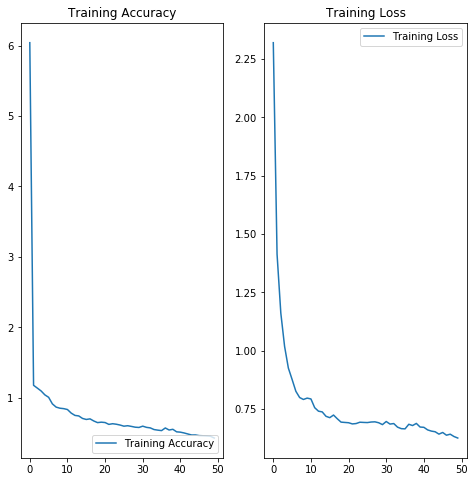

In [29]:
#Pulling some pretty graphs for training

acc = history.history['MSE']

loss=history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()